In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [2]:
import os
import sys

# Ensure no W&B logging will be performed
sys.argv = "main.py -log tb -name tst -reset 1 -lm.eval.enable 0 -log tb -batch_size 20 -restore /cm/shared/anonymous/moeut_training_code/save/slimpajama_moe_no_attmoe_154M_sigmoid_standard_lb_v2/checkpoint/model-100000.pth".split(" ")

# Pretend we are in the main directory
os.chdir("../../")

In [3]:
import os
os.environ["MOE_TYPE"] = "moe_layer"
os.environ.get("MOE_TYPE", "moe_layer")

'moe_layer'

In [4]:
from main import initialize
import torch
import torch.nn.functional as F
from layers import MoE
import matplotlib.pyplot as plt
import pickle
import numpy as np

print(MoE)

/cm/archive/anonymous/miniconda3/envs/moeut/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-04-04 14:55:51,501] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/cm/archive/anonymous/miniconda3/envs/moeut/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/cm/archive/anonymous/miniconda3/envs/moeut/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


<class 'layers.moe_layer.MoE'>


: 

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams['text.usetex'] = False #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = '\\usepackage{sansmath}\n\\sansmath' #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'DejaVu Sans' # Change from 'Arial' to 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial' # Choose a nice font here

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

In [7]:
helper, task = initialize()
task.create_data_fetcher()

orig_run_model_valid = task.run_model_validation

Restoring: /cm/shared/anonymous/moeut_training_code/save/slimpajama_moe_no_attmoe_154M_deepseek_sigmoidonly_v2/checkpoint/model-100000.pth...


No distributed environment detected
Resetting training state...
Port already used: 7000
Found tensorboard in /cm/archive/anonymous/miniconda3/envs/moeut/bin/tensorboard
Starting Tensorboard server on 7001
Done.
Available GPUs: 1
SlimPajama: Generating map...
Map done.
SlimPajama: Loaded tokenizer.
SlimPajama: 58345 chunks missing
Token limit reached. No need to tokenize more.
SlimPajama: Limiting to first 164 chunks because limited to 2050048000 tokens
SlimPajama: Loaded tokenizer.
SlimPajama: 31345 chunks missing
Token limit reached. No need to tokenize more.
SlimPajama: Limiting to first 59 chunks because limited to 1032192 tokens
Weight info:
  n_model_weights: 149718016
  n_attention_weights: 10747904
  n_non_attnetion_weights: 138970112
  attention_precent: 0.07178764645131284
Training in bfloat16...
Total number of model parameters: 157919040
Loading state
Loading run_invariants
Loading sampler
Loading interface
Loading optimizer
Loading scaler
Loading model


/cm/shared/anonymous/moeut_training_code/tasks/lm_base.py:115: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  data = torch.tensor(res, dtype=torch.long, device=self.helper.device).T


In [8]:
nexp = task.helper.args.moe.n_experts
ntok = task.helper.args.sentencepiece.n_pieces

nlayers = task.helper.args.transformer.encoder_n_layers
ngrp = 16

token_counts = 0

counts = torch.zeros(ngrp, nlayers // ngrp, nexp, ntok)

In [9]:
counts.size()

torch.Size([16, 1, 64, 8000])

In [10]:
global this_data

def run_model_validation(self, data):
    global token_counts
    global this_data

    token_counts = token_counts + F.one_hot(data["data"].flatten().long(), ntok).sum(0)

    this_data = data
    return orig_run_model_valid(data)

task.run_model_validation = run_model_validation.__get__(task)
task

In [11]:
id_map = {}

def patch_module(module):

    myid = id(module)
    if myid in id_map:
        return

    gid = len(id_map)
    id_map[myid] = gid

    # sel_val, sel_index = self.topk(

    def new_topk(self, *args, **kwargs):
        nonlocal gid
        global this_data
        data = this_data["data"][:-1].T

        sel_val, sel_index = MoE.topk(self, *args, **kwargs)

        assert data.shape == sel_index.shape[:-1]

        data = data.reshape(-1)

        # Shape of counts[gid]: nexp, ntok
        # Linear index: expert * ntok + tok

        seli = sel_index.flatten(end_dim=-2) * ntok
        addi = seli + data[..., None]
        addi = addi.flatten().cpu()

        counts[gid][self.layer // ngrp].flatten().index_add_(0, addi, torch.ones_like(addi, dtype=torch.float32))

        return sel_val, sel_index


    module.topk = new_topk.__get__(module)

In [12]:
for m in task.model.modules():
    if isinstance(m, MoE):
        patch_module(m)

In [13]:
task.validate()

Starting validation on val...


  0%|          | 0/100 [00:00<?, ?it/s]

New shape: (torch.Size([10, 1024, 512]), torch.Size([64, 512, 128]))
New shape: (torch.Size([10, 1024, 6, 128]), torch.Size([64, 128, 512]))
New shape: (torch.Size([10, 1024, 512]), torch.Size([1, 512, 256]))
New shape: (torch.Size([10, 1024, 1, 256]), torch.Size([1, 256, 512]))


100%|██████████| 100/100 [01:32<00:00,  1.08it/s]

Validation done on worker 0.
Validation accuracy on val: 0.4787197265625


{'val/loss': 2.6128864326477053,
 'val/accuracy': 0.4787197265625,
 'val/perplexity': 13.638360300933885,
 'val/time_since_best_loss': 0,
 'val/time_since_best_accuracy': 0,
 'mean_accuracy': 0.4787197265625,
 'mean_loss': 2.6128864383697508}

In [14]:
order = torch.argsort(token_counts, descending=True).cpu()
token_counts_o = token_counts.cpu()[order]
counts_o = counts[:, :, :, order]

In [6]:
counts.size()

NameError: name 'counts' is not defined

In [7]:
counts_o[0]

NameError: name 'counts_o' is not defined

In [17]:
def jains_fairness_index(routing_weights: torch.Tensor) -> torch.Tensor:
    # Sum over tokens to get total weight assigned to each expert
    expert_usage = routing_weights.sum(dim=0)  # Shape: (num_experts,)

    # Normalize expert usage to get probabilities
    total_usage = expert_usage.sum()
    if total_usage == 0:
        return torch.tensor(0.0)  # Handle edge case where no tokens are routed

    p_i = expert_usage / total_usage  # Shape: (num_experts,)

    # Compute Jain's Fairness Index
    jfi = (p_i.sum() ** 2) / (p_i.shape[0] * (p_i ** 2).sum())

    return jfi


def compute_shannon_entropy(gating_probs: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    num_tokens = gating_probs.size(0)
    total_entropy = 0.0
    entropy_list = []

    for i in range(num_tokens):
        token_probs = gating_probs[i]
        if torch.sum(token_probs) < eps:
            continue
        log_probs = torch.log(token_probs + eps)
        entropy = - torch.sum(token_probs * log_probs)
        total_entropy += entropy
        entropy_list.append(entropy)

    avg_entropy = total_entropy / num_tokens

    return avg_entropy, entropy_list

In [18]:
def plot_over_layer(deepseek_dict, shared_dict, ylabel, save_path):
    # Extract the x-axis (keys) and corresponding y-axis (values)

    x_deepseek = sorted(deepseek_dict.keys())
    y_deepseek = [deepseek_dict[k] for k in x_deepseek]

    x_shared = sorted(shared_dict.keys())
    y_shared = [shared_dict[k] for k in x_shared]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x_deepseek, y_deepseek, marker='o', label='DeepSeek (Sigmoid)')
    plt.plot(x_shared, y_shared, marker='s', label='Shared Only (Softmax)')

    # Add labels, title, legend, and grid
    plt.xlabel('Layer_ids')
    # plt.ylabel('Norm Peakedness')
    plt.ylabel(ylabel)
    plt.xticks(range(16))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(save_path, format='pdf', bbox_inches='tight')

    # Show the plot
    plt.show()

In [19]:
# Add this code to decode tokens
def decode_tokens(token_ids):
    """Decode token IDs to their string representations"""
    # Use the vocabulary from the task's train set
    decoded_tokens = []
    for token_id in token_ids:
        token = task.train_set.vocabulary.to_string([token_id])
        decoded_tokens.append(token)
    return decoded_tokens

ostart = 0
count = 20
gid = 15
layer = 0

# Get the token IDs
token_ids = order[ostart:ostart+count].tolist()

# Decode the tokens
decoded_tokens = decode_tokens(token_ids)

# Print token IDs and their decoded values
for i, (token_id, token_text) in enumerate(zip(token_ids, decoded_tokens)):
    print(f"Token {i}: ID={token_id}, Text='{token_text}'")

Token 0: ID=7857, Text='.'
Token 1: ID=7859, Text=','
Token 2: ID=10, Text='the'
Token 3: ID=35, Text='of'
Token 4: ID=33, Text='and'
Token 5: ID=31, Text='to'
Token 6: ID=7836, Text=''
Token 7: ID=4, Text='a'
Token 8: ID=32, Text='in'
Token 9: ID=7844, Text='s'
Token 10: ID=7869, Text='1'
Token 11: ID=7868, Text='''
Token 12: ID=7866, Text='0'
Token 13: ID=7870, Text='-'
Token 14: ID=7874, Text='2'
Token 15: ID=64, Text='is'
Token 16: ID=96, Text='that'
Token 17: ID=66, Text='for'
Token 18: ID=29, Text='ed'
Token 19: ID=70, Text='on'


In [20]:
ostart = 0
count = 6000
# gid = 15
layer = 0

entropies = {}
entropy_lists = {}
jains_fairness_indexs = {}

for gid in range(16):
    # labels = task.train_set.vocabulary(order[ostart:ostart+count].tolist())

    # fig, ax=plt.subplots(figsize=(16, 8))
    if layer is None:
        plot_slice = counts_o[gid, :, :, ostart:ostart+count]
        plot_slice = plot_slice.sum(0)
    else:
        plot_slice = counts_o[gid, layer, :, ostart:ostart+count]

    plot_slice = plot_slice / plot_slice.sum(0, keepdim=True)

    plot_slice = plot_slice.T

    tresh = torch.quantile(plot_slice, 0.95, dim=0, keepdim=True)
    # tresh = 0
    total_counts = plot_slice * (plot_slice >= tresh)
    total_counts = total_counts / total_counts.sum(0, keepdim=True)
    # plot_slice = total_counts
    total_counts = total_counts * torch.arange(plot_slice.shape[0], dtype=torch.float)[..., None]
    total_counts = total_counts.sum(0)
    order3 = total_counts.argsort(descending=False)

    plot_slice_o = plot_slice[:, order3]

    # modify part
    score, index = plot_slice_o.topk(6, dim=-1, sorted=False)
    score = score / (score.sum(dim=-1, keepdim=True) + 1e-20)
    plot_slice_o_topk = torch.zeros_like(plot_slice_o)
    plot_slice_o_topk = plot_slice_o_topk.scatter(-1, index, score)

    avg_entropy, entropy_list = compute_shannon_entropy(plot_slice_o_topk)
    entropies[gid] = float(avg_entropy)
    entropy_lists[gid] = entropy_list

    jains_fairness_indexs[gid] = float(jains_fairness_index(plot_slice_o_topk))

In [1]:
plot_slice_o_topk

NameError: name 'plot_slice_o_topk' is not defined

In [22]:
# np_data = plot_slice_o_topk.numpy()
# np.save(f"/cm/shared/anonymous/moeut_training_code/tmp/layer_{gid}_router_output.npy", np_data)

(plot_slice_o_topk.numpy() > 0).astype(int)[0]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [23]:
np.load("/cm/shared/anonymous/moeut_training_code/tmp/layer_15_logits_100k.npy")

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [24]:
plot_slice_o_topk_saved = np.load("/cm/shared/anonymous/moeut_training_code/tmp/layer_15_router_output.npy")
plot_slice_o_topk_saved

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.15802382, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.16438356, 0.20547947,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.2631579 , 0.12280701,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [25]:
np.save(f"/cm/shared/anonymous/moeut_training_code/tmp/layer_{gid}_logits_100k.npy", (plot_slice_o_topk_saved > 0).astype(int))

In [26]:
# save the entropy list
with open("./tmp/entropy_lists_deepseek.pkl", "wb") as f:
    pickle.dump(entropy_lists, f)

# load the entropy list
with open("./tmp/entropy_lists_deepseek.pkl", "rb") as f:
    entropy_lists_deepseek = pickle.load(f)

In [27]:
jains_fairness_indexs

{0: 0.941391110420227,
 1: 0.8321981430053711,
 2: 0.7784545421600342,
 3: 0.7480964660644531,
 4: 0.759623646736145,
 5: 0.7564991116523743,
 6: 0.7749559879302979,
 7: 0.7880728244781494,
 8: 0.7679876685142517,
 9: 0.7486655116081238,
 10: 0.7897233963012695,
 11: 0.7959731221199036,
 12: 0.7568156123161316,
 13: 0.7306919693946838,
 14: 0.7640947699546814,
 15: 0.7846947908401489}

In [28]:
jains_fairness_indexs_shared = {0: 0.9470109343528748,
 1: 0.850326418876648,
 2: 0.8117069005966187,
 3: 0.7388167381286621,
 4: 0.7615943551063538,
 5: 0.7498993277549744,
 6: 0.7498918175697327,
 7: 0.7539627552032471,
 8: 0.7648742198944092,
 9: 0.776200532913208,
 10: 0.7773122191429138,
 11: 0.8021807074546814,
 12: 0.7485731244087219,
 13: 0.7623348236083984,
 14: 0.7814239859580994,
 15: 0.7801554799079895}

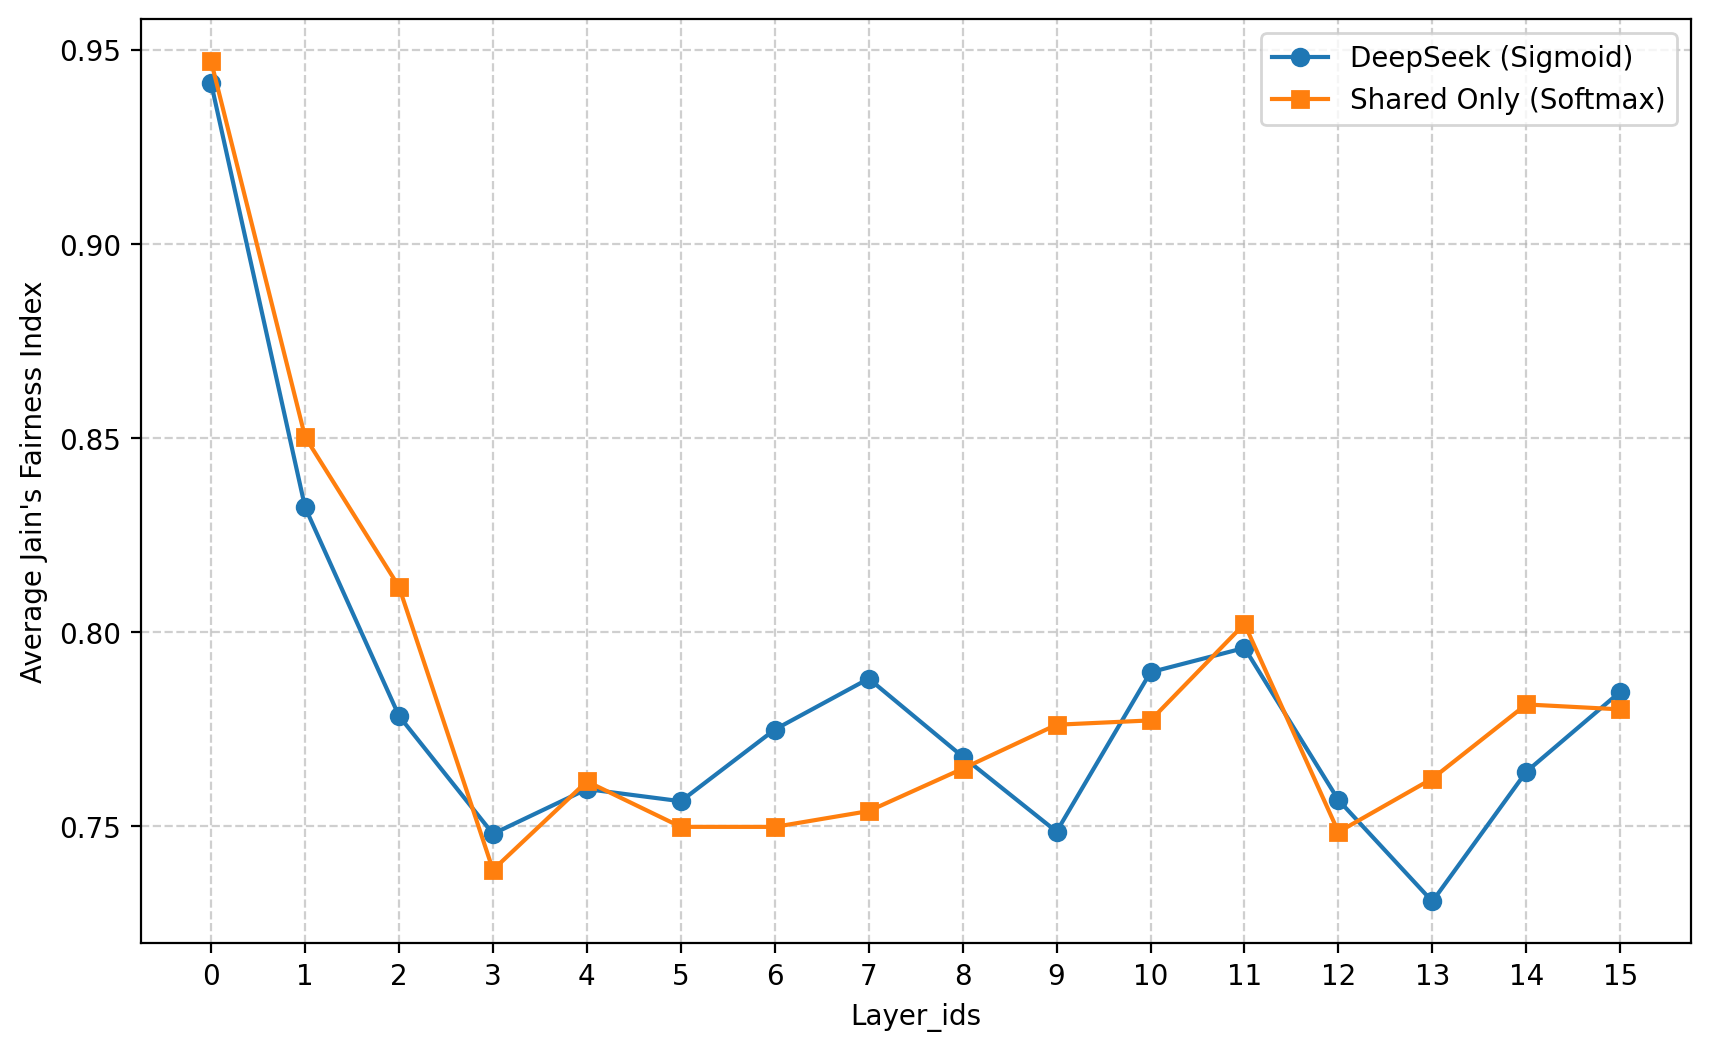

In [29]:
plot_over_layer(jains_fairness_indexs, jains_fairness_indexs_shared, ylabel="Average Jain's Fairness Index",
save_path="/cm/shared/anonymous/moeut_training_code/paper/deepseek/figs/jain_deepseek_shared.pdf")

In [30]:
entropies

{0: 1.7737561464309692,
 1: 1.76356840133667,
 2: 1.753343939781189,
 3: 1.7482264041900635,
 4: 1.749277949333191,
 5: 1.7475625276565552,
 6: 1.7462559938430786,
 7: 1.7475911378860474,
 8: 1.7495449781417847,
 9: 1.7454622983932495,
 10: 1.745445966720581,
 11: 1.7442487478256226,
 12: 1.7426990270614624,
 13: 1.7408499717712402,
 14: 1.742175579071045,
 15: 1.7412464618682861}

In [31]:
entropies_shared = {0: 1.7817132472991943,
 1: 1.7666350603103638,
 2: 1.7588359117507935,
 3: 1.7480708360671997,
 4: 1.7484875917434692,
 5: 1.7451826333999634,
 6: 1.7484900951385498,
 7: 1.7472343444824219,
 8: 1.7494306564331055,
 9: 1.7467029094696045,
 10: 1.7465277910232544,
 11: 1.7463064193725586,
 12: 1.7443379163742065,
 13: 1.7451863288879395,
 14: 1.7459604740142822,
 15: 1.7440670728683472}

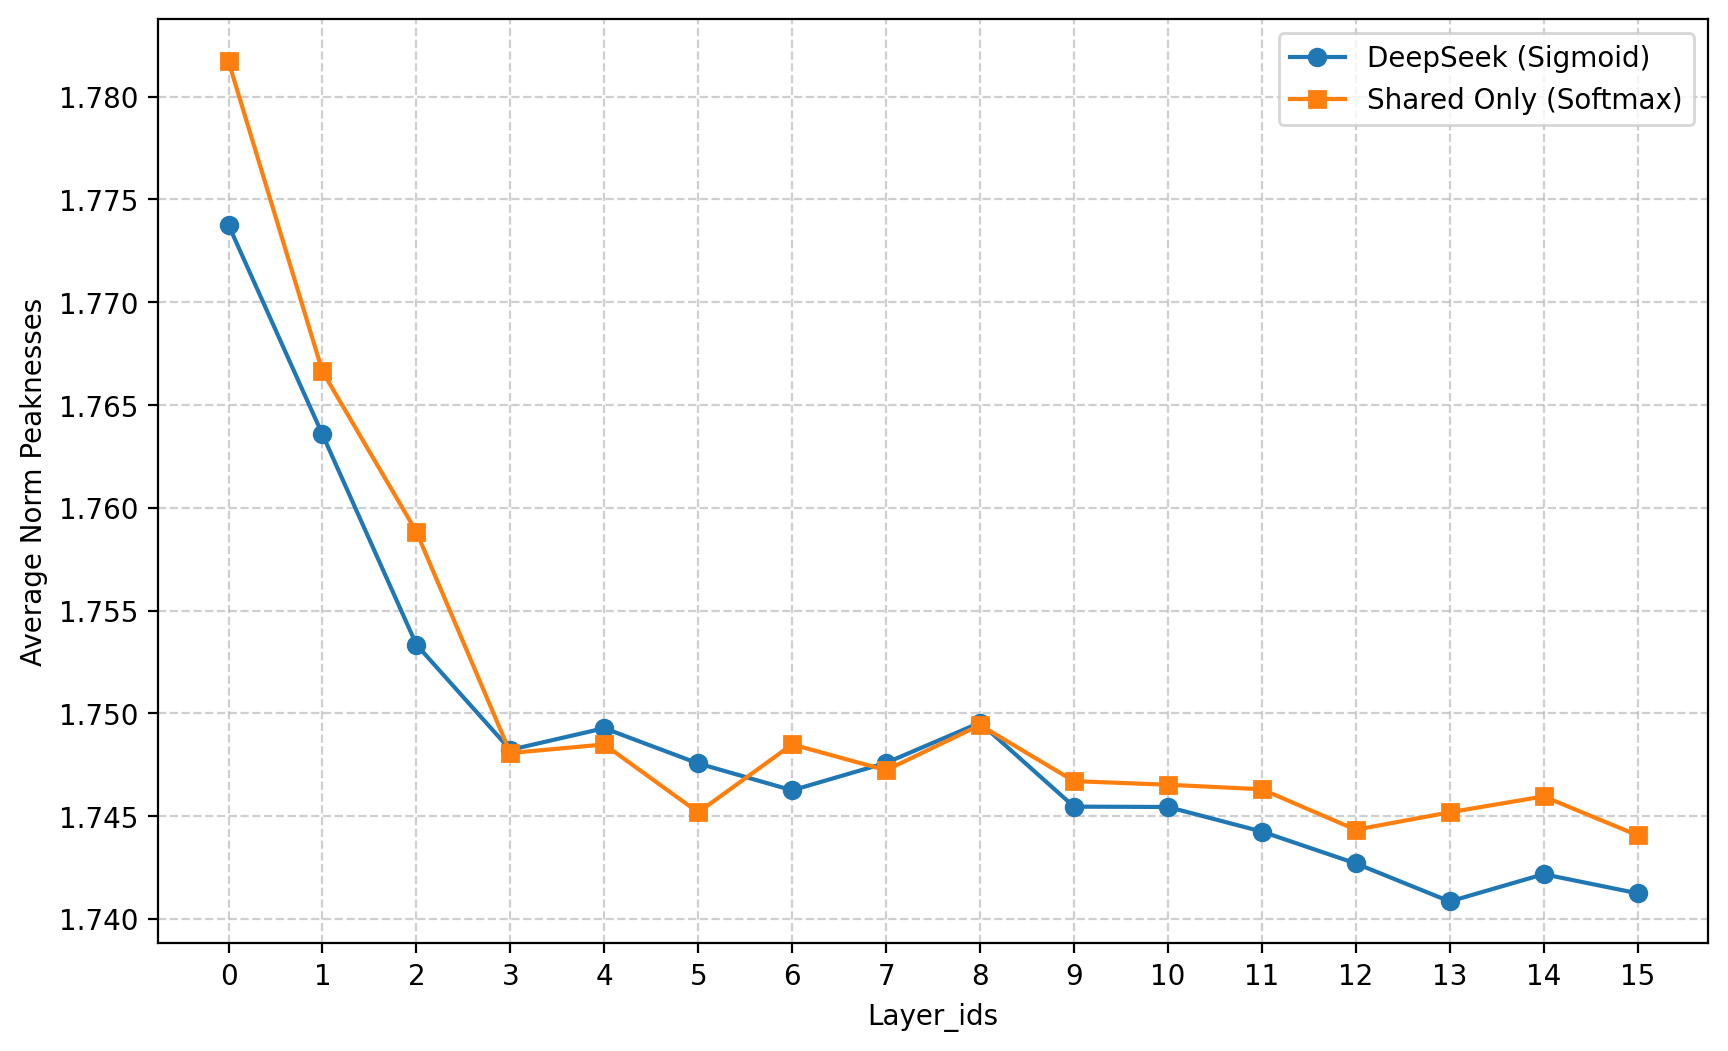

In [32]:
plot_over_layer(entropies, entropies_shared, ylabel="Average Norm Peaknesses",
save_path="/cm/shared/anonymous/moeut_training_code/paper/deepseek/figs/norm_peakness_deepseek_shared.pdf")

## Visualize the histogram of the entropy list

In [33]:
# load the entropy list of both sigmoid and softmax
with open("./tmp/entropy_lists_deepseek.pkl", "rb") as f:
    entropy_lists_deepseek = pickle.load(f)

with open("./tmp/entropy_lists_shared.pkl", "rb") as f:
    entropy_lists_shared = pickle.load(f)

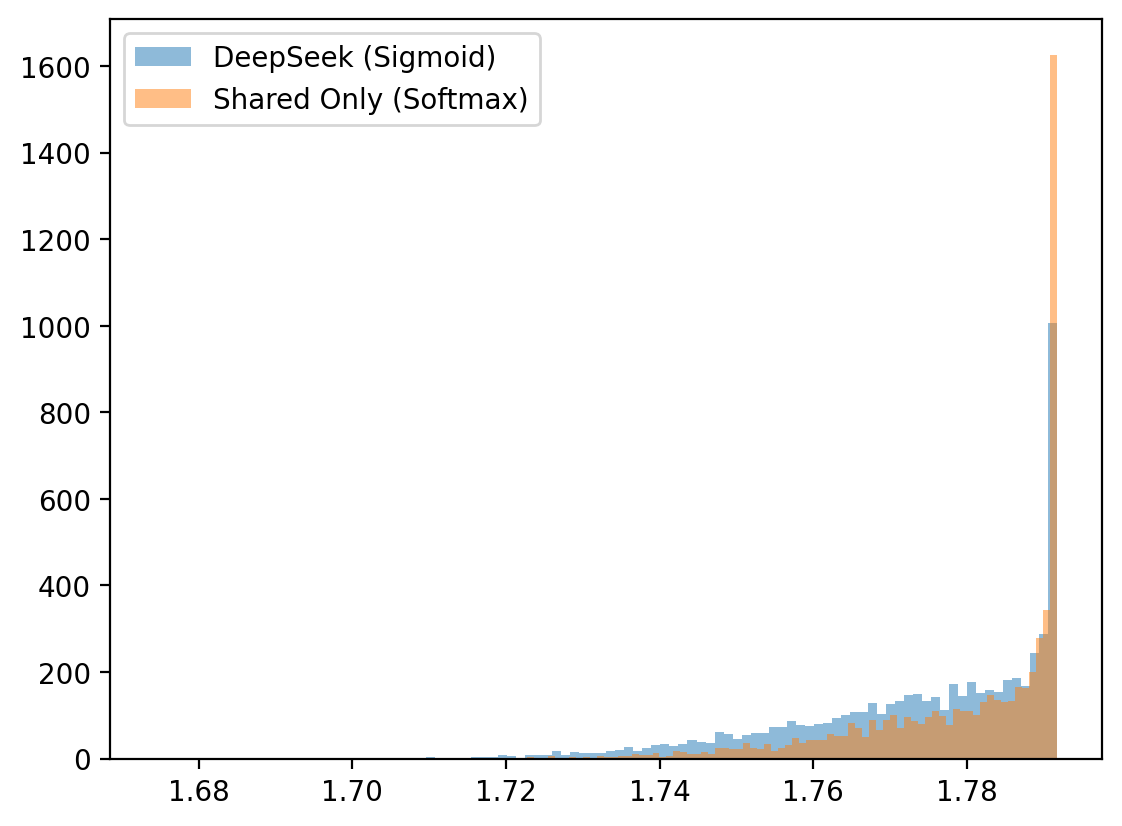

In [34]:
# plot the histogram of the entropy list in layer 0
plt.hist(entropy_lists_deepseek[0], bins=100, alpha=0.5, label='DeepSeek (Sigmoid)')
plt.hist(entropy_lists_shared[0], bins=100, alpha=0.5, label='Shared Only (Softmax)')
plt.legend()
plt.show()

## Visualize the output of the router

0.17285497


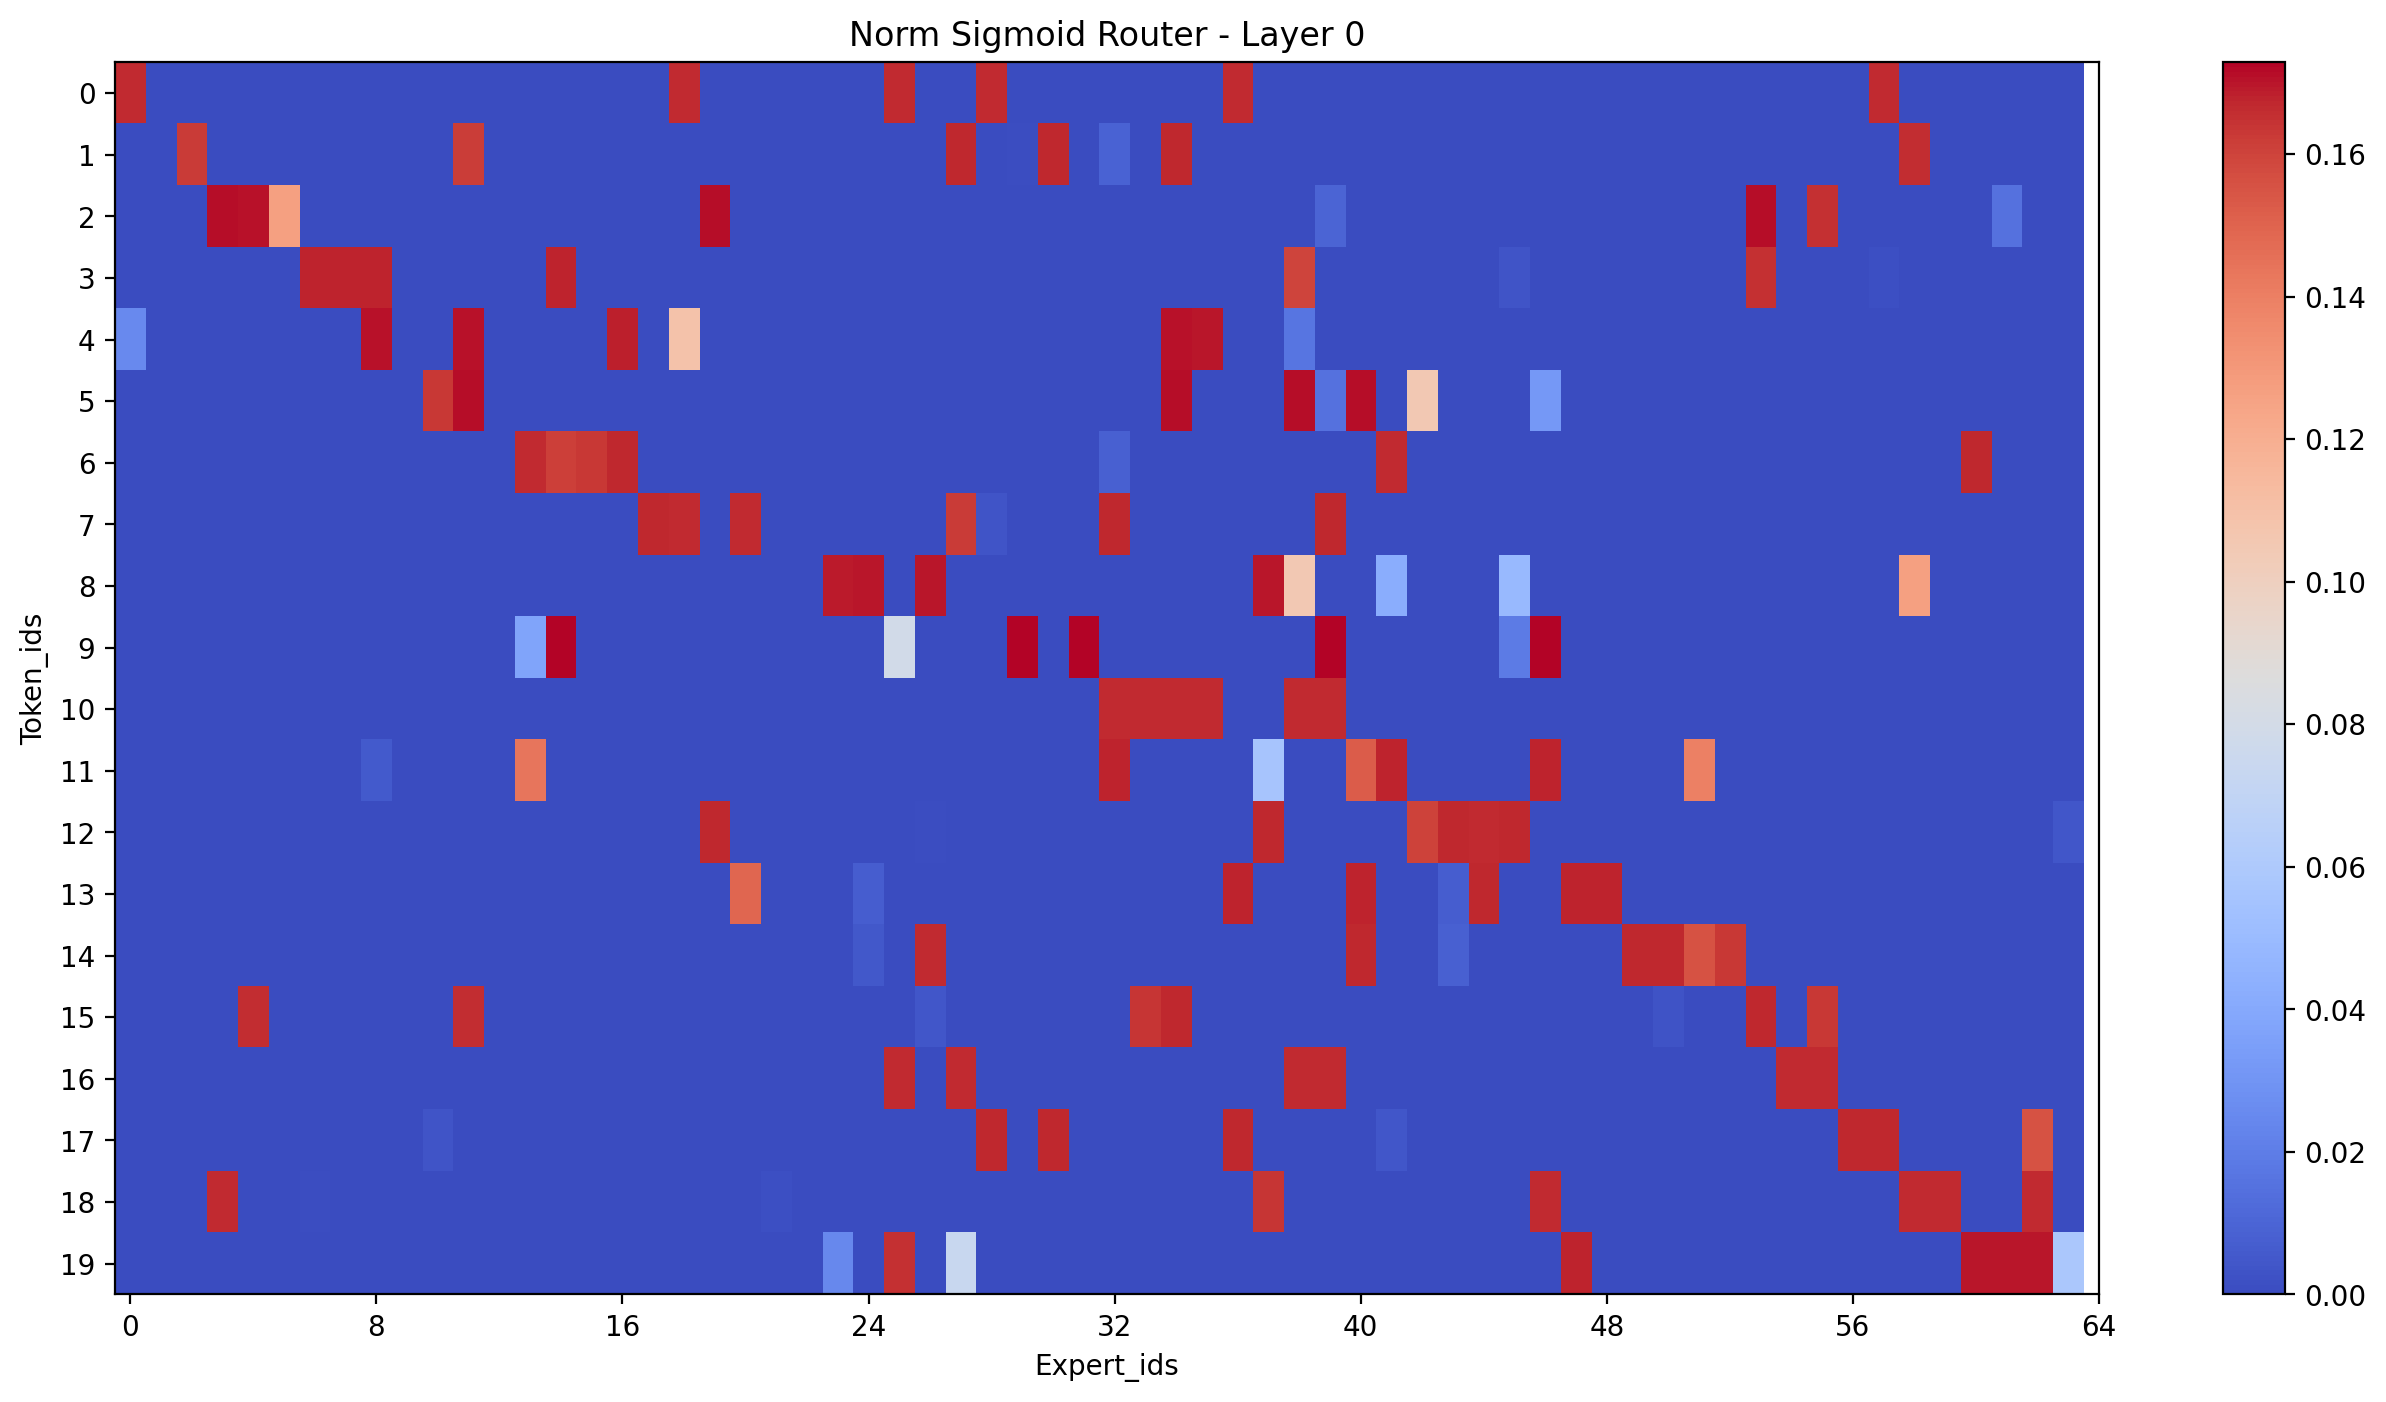

0.2552849


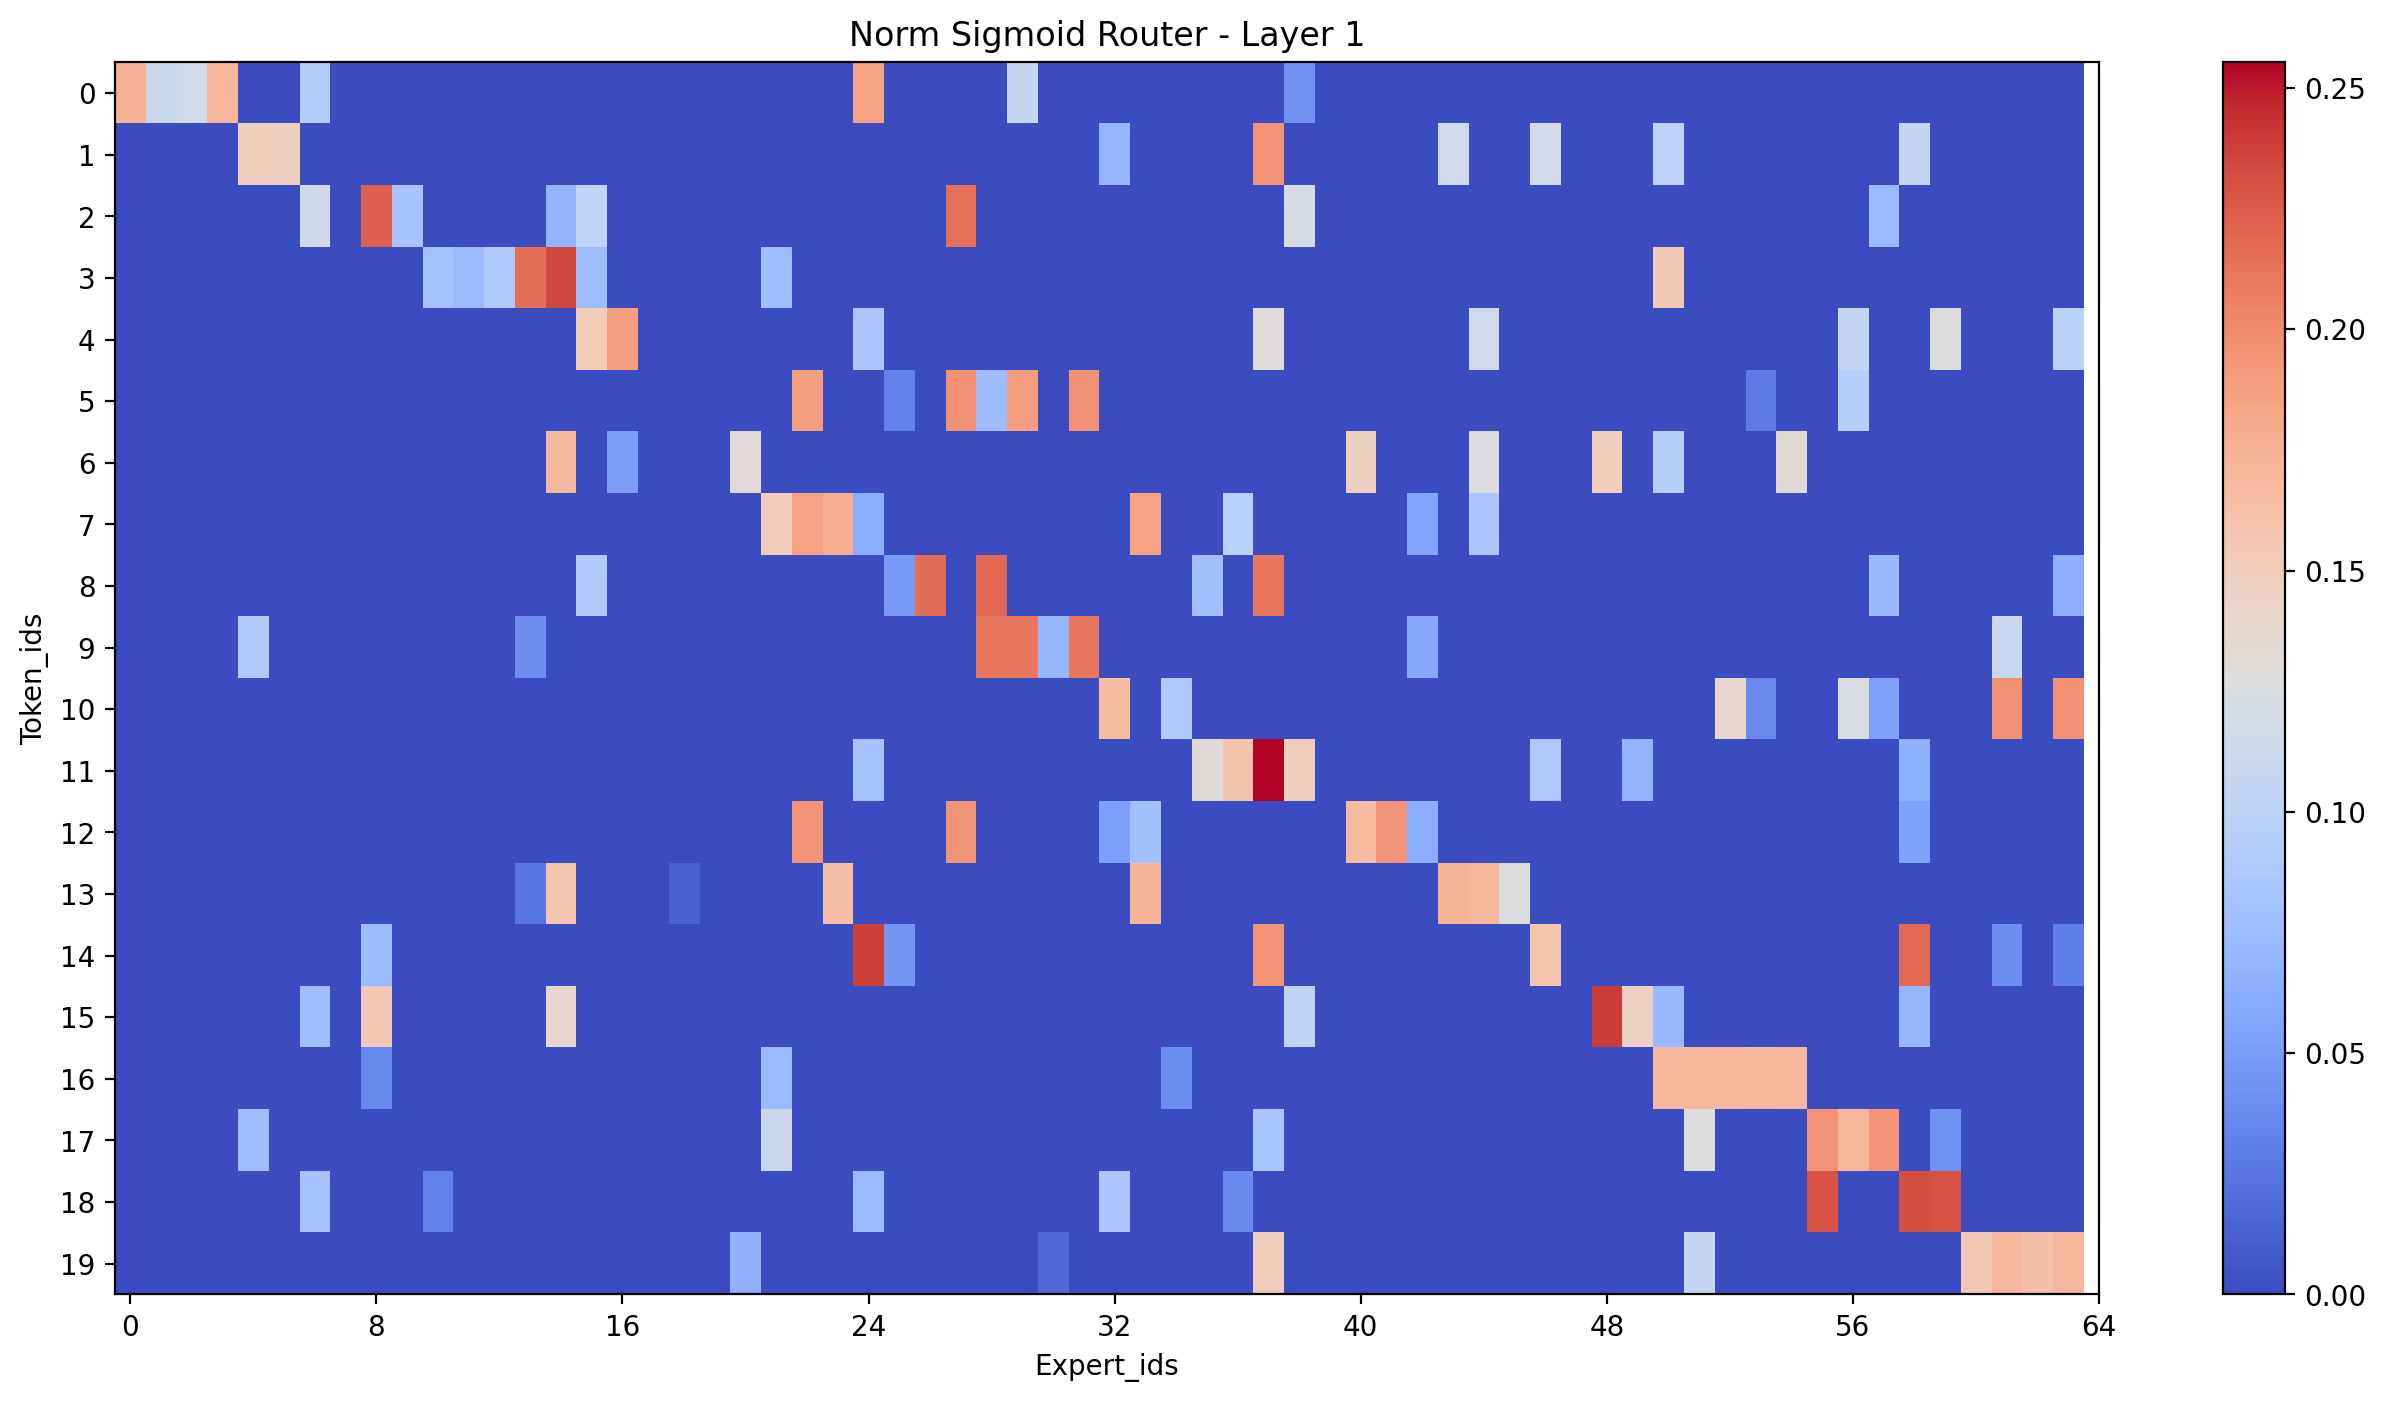

0.28047413


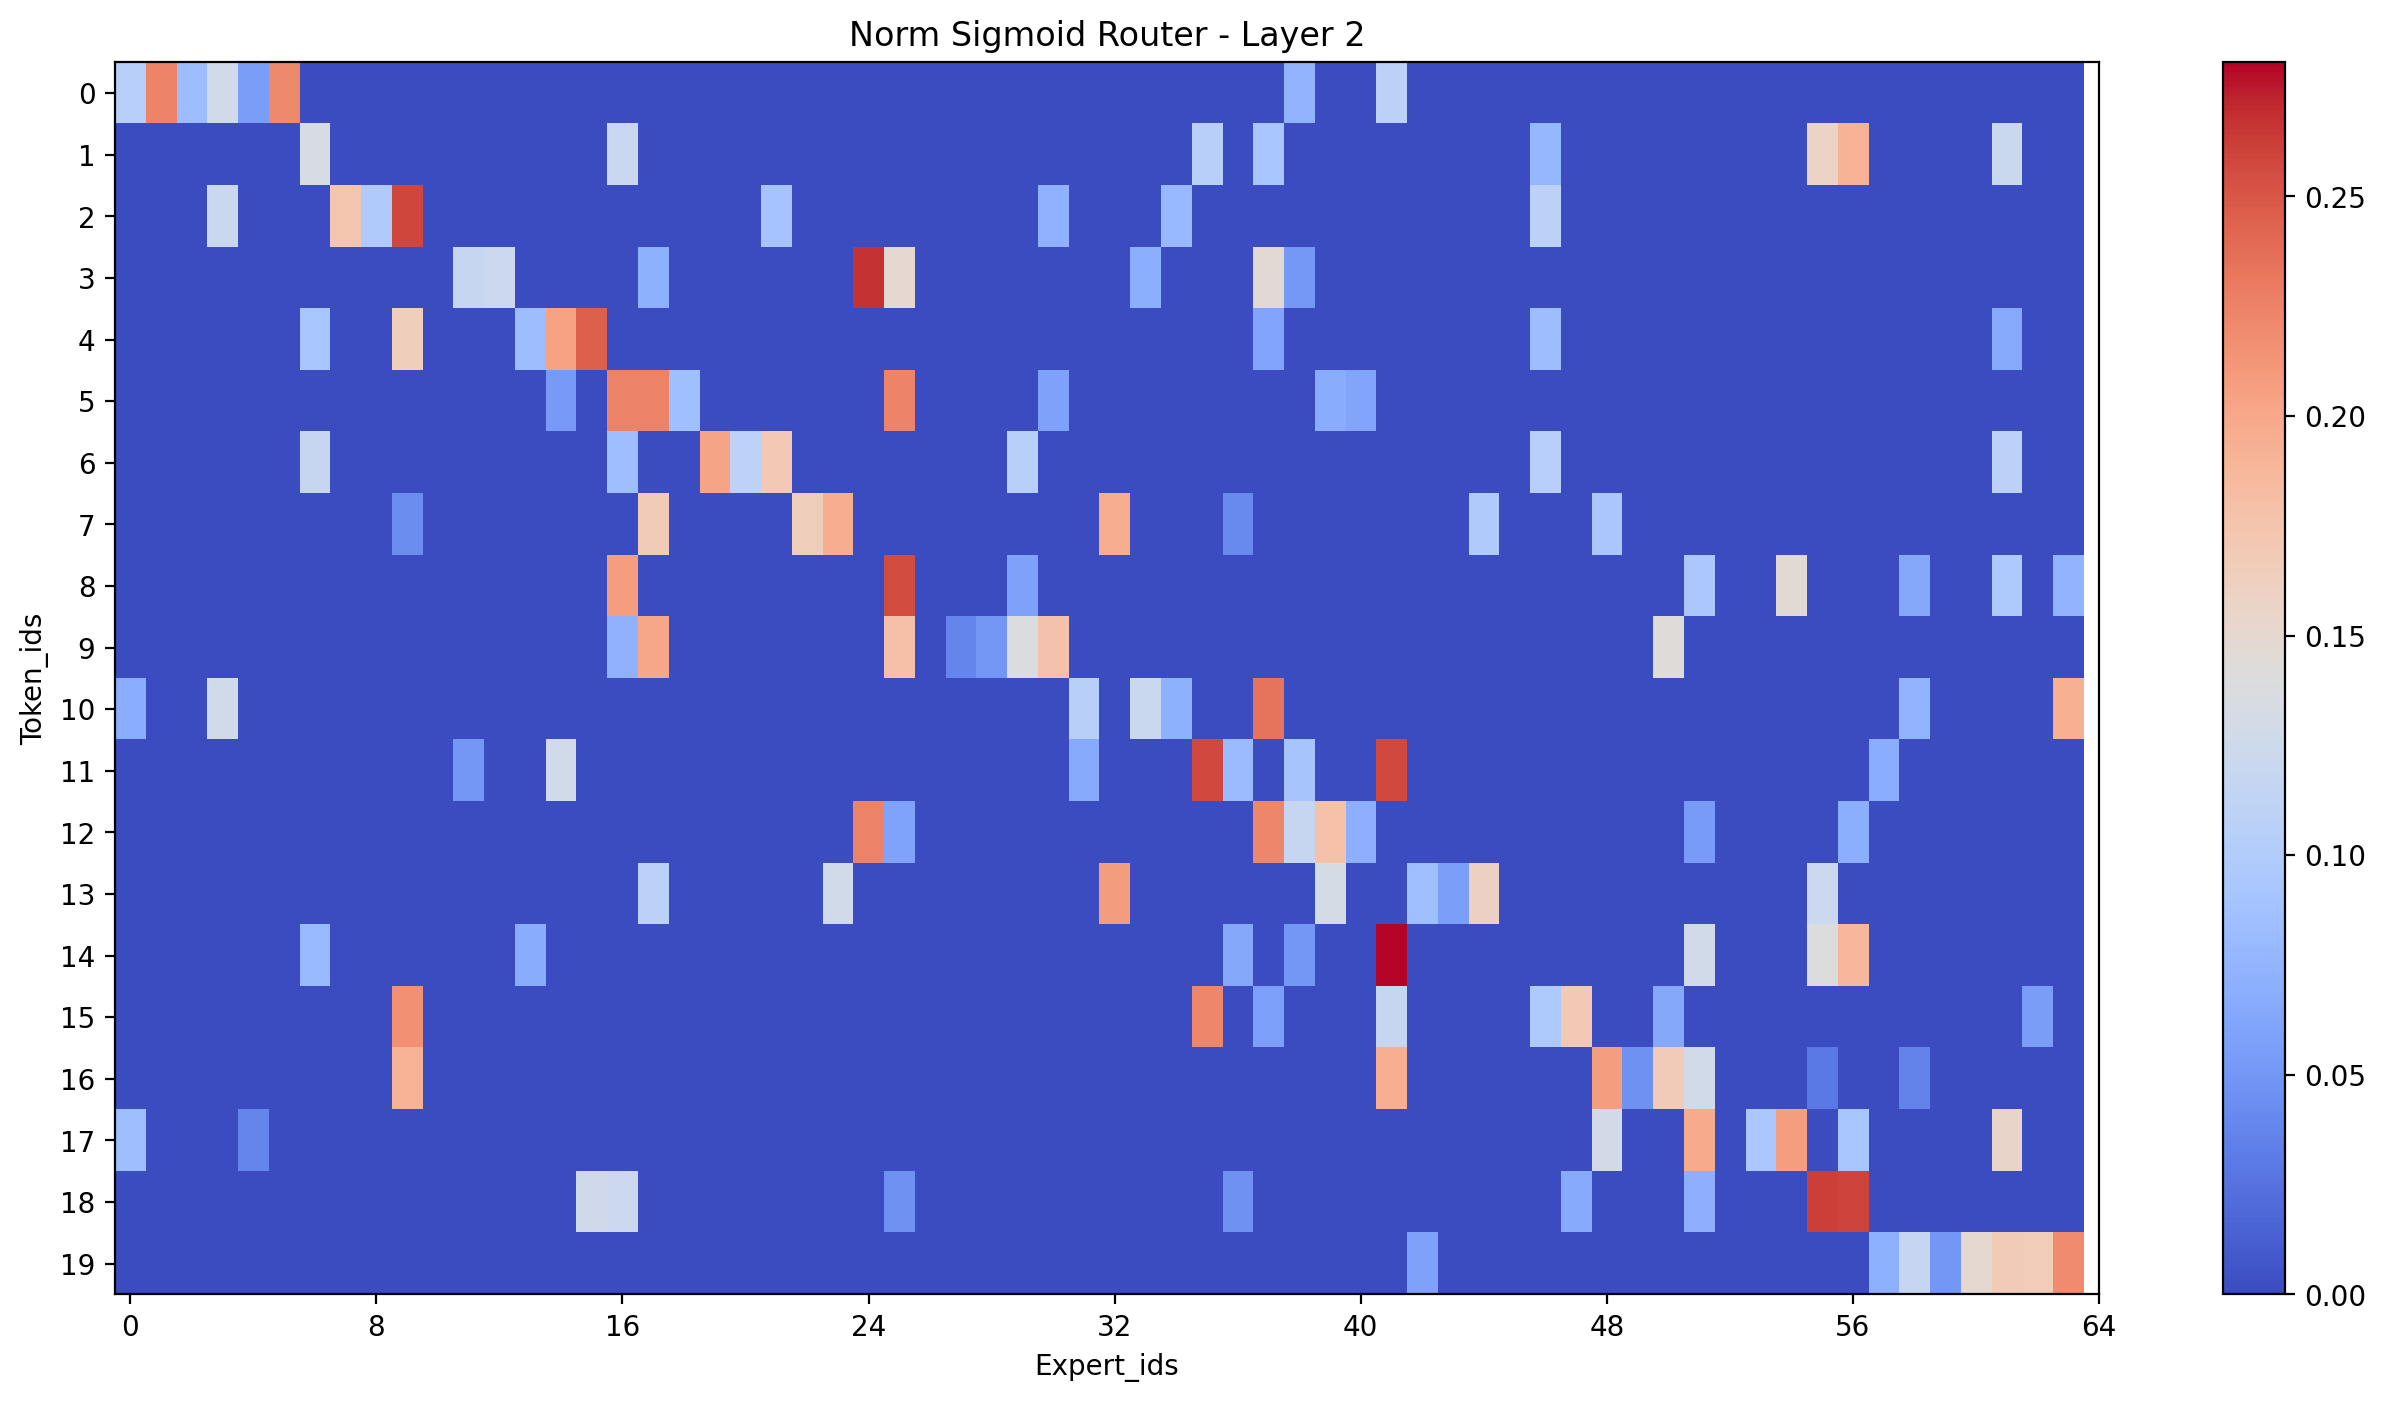

0.28893754


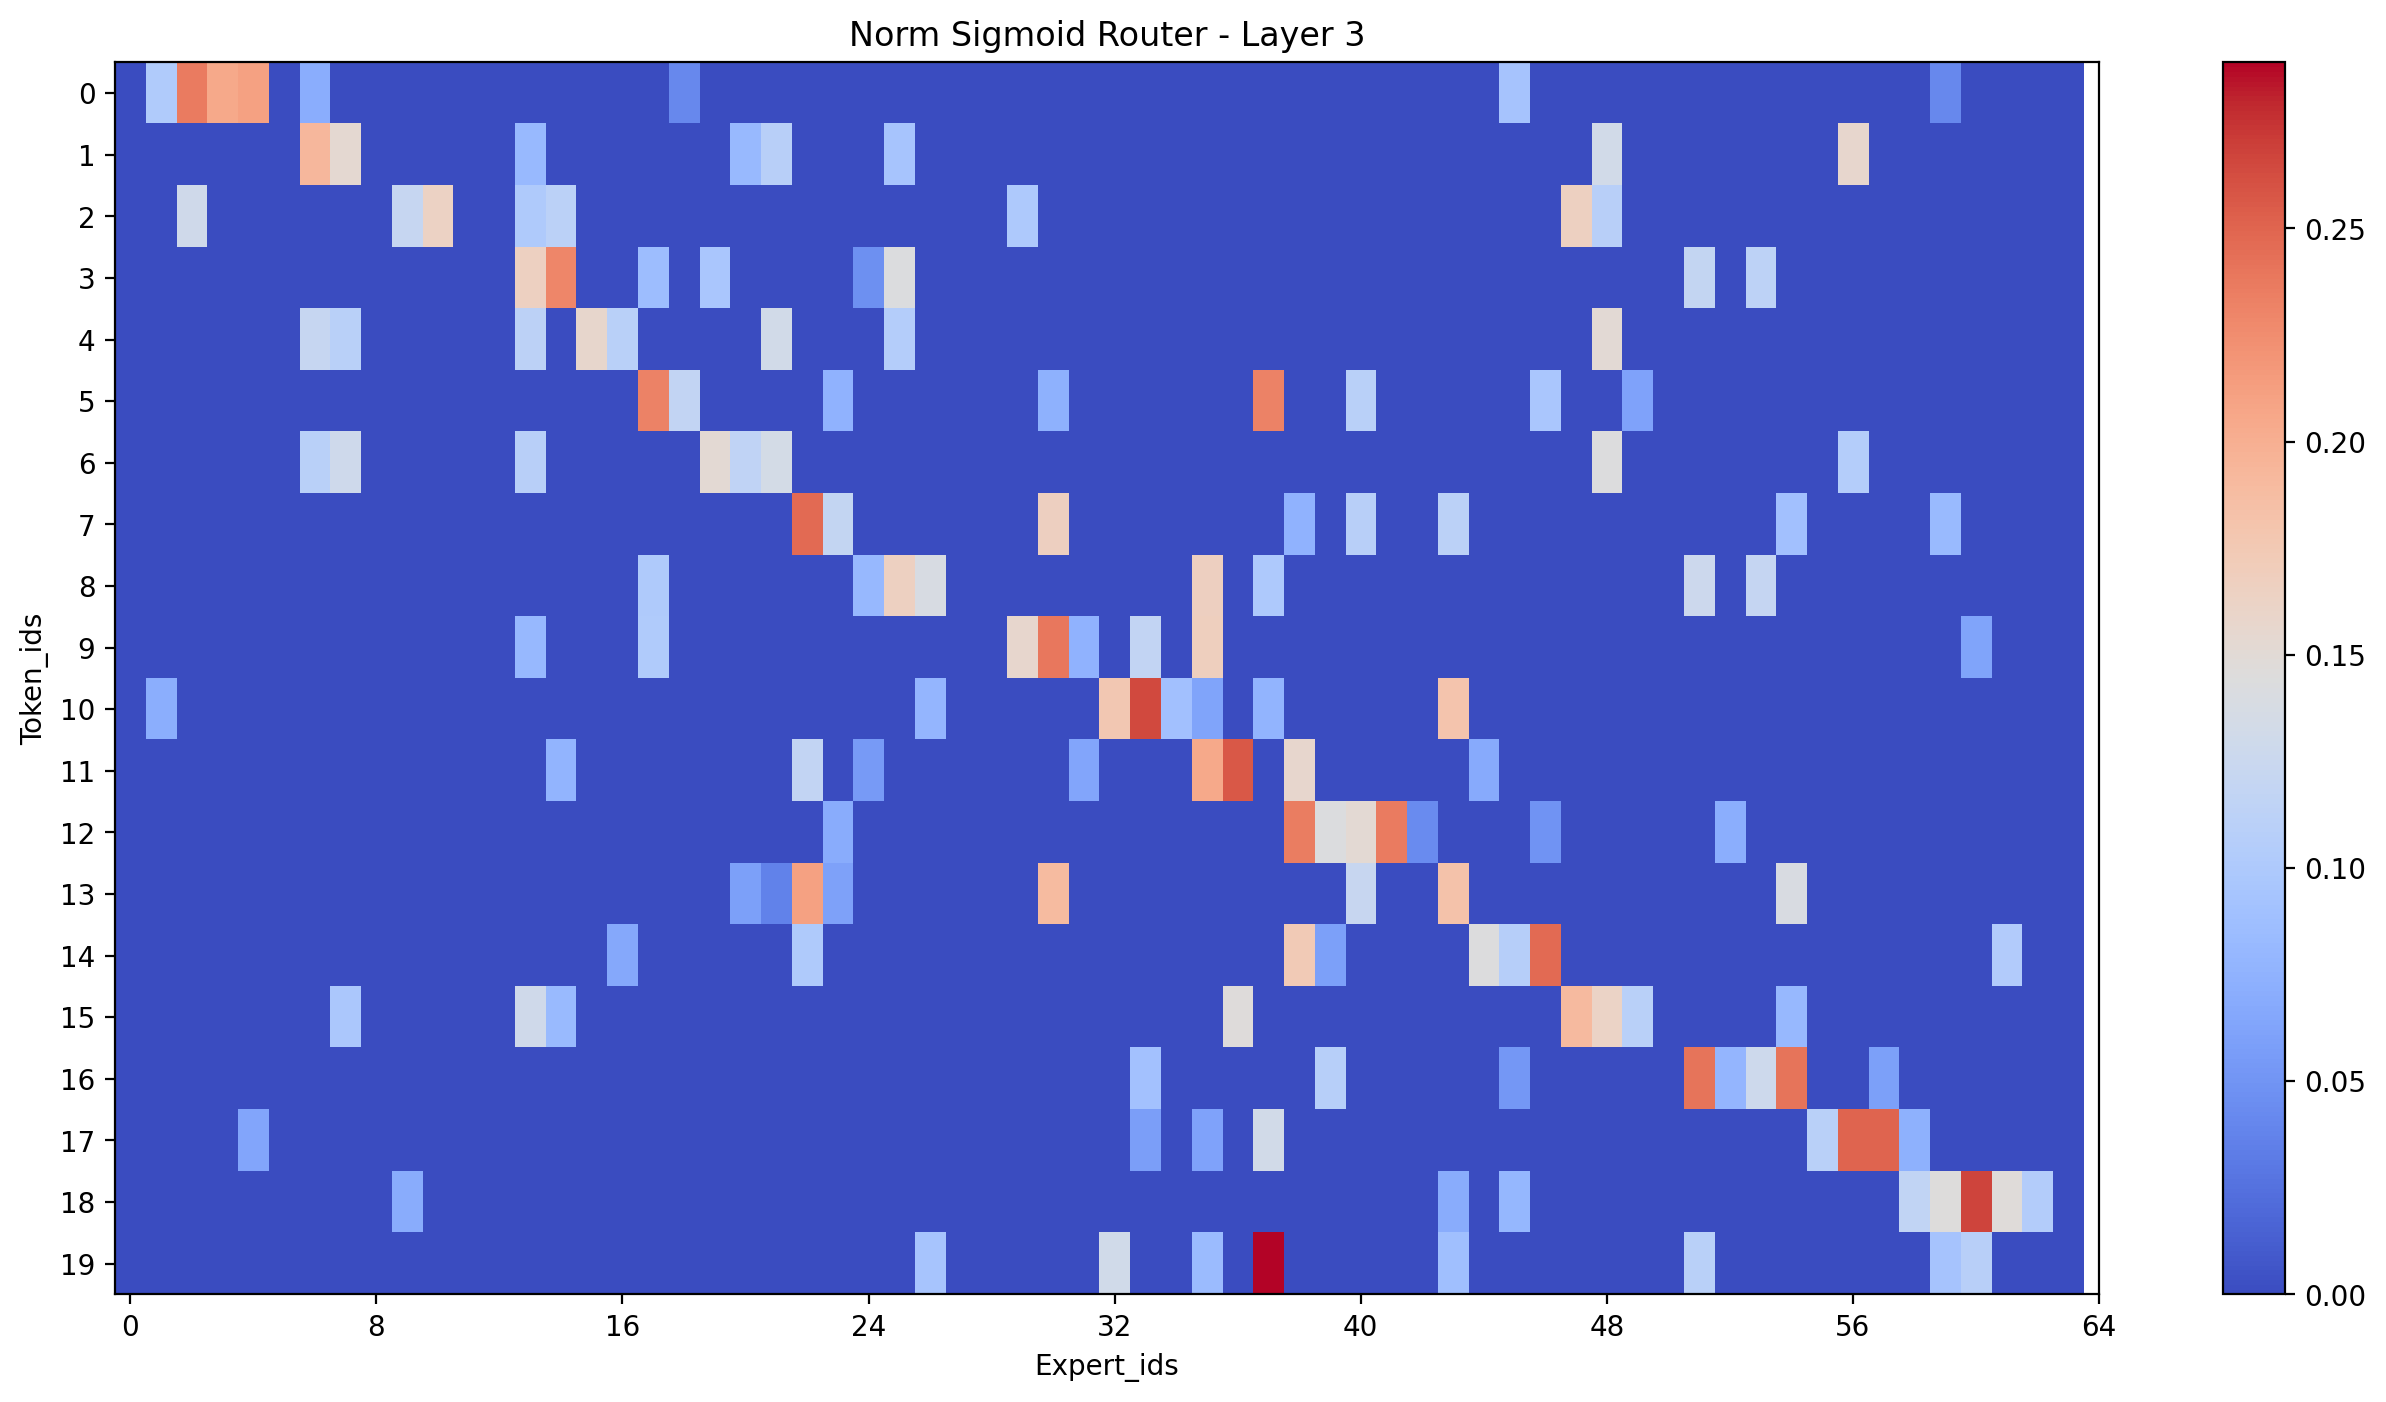

0.27635947


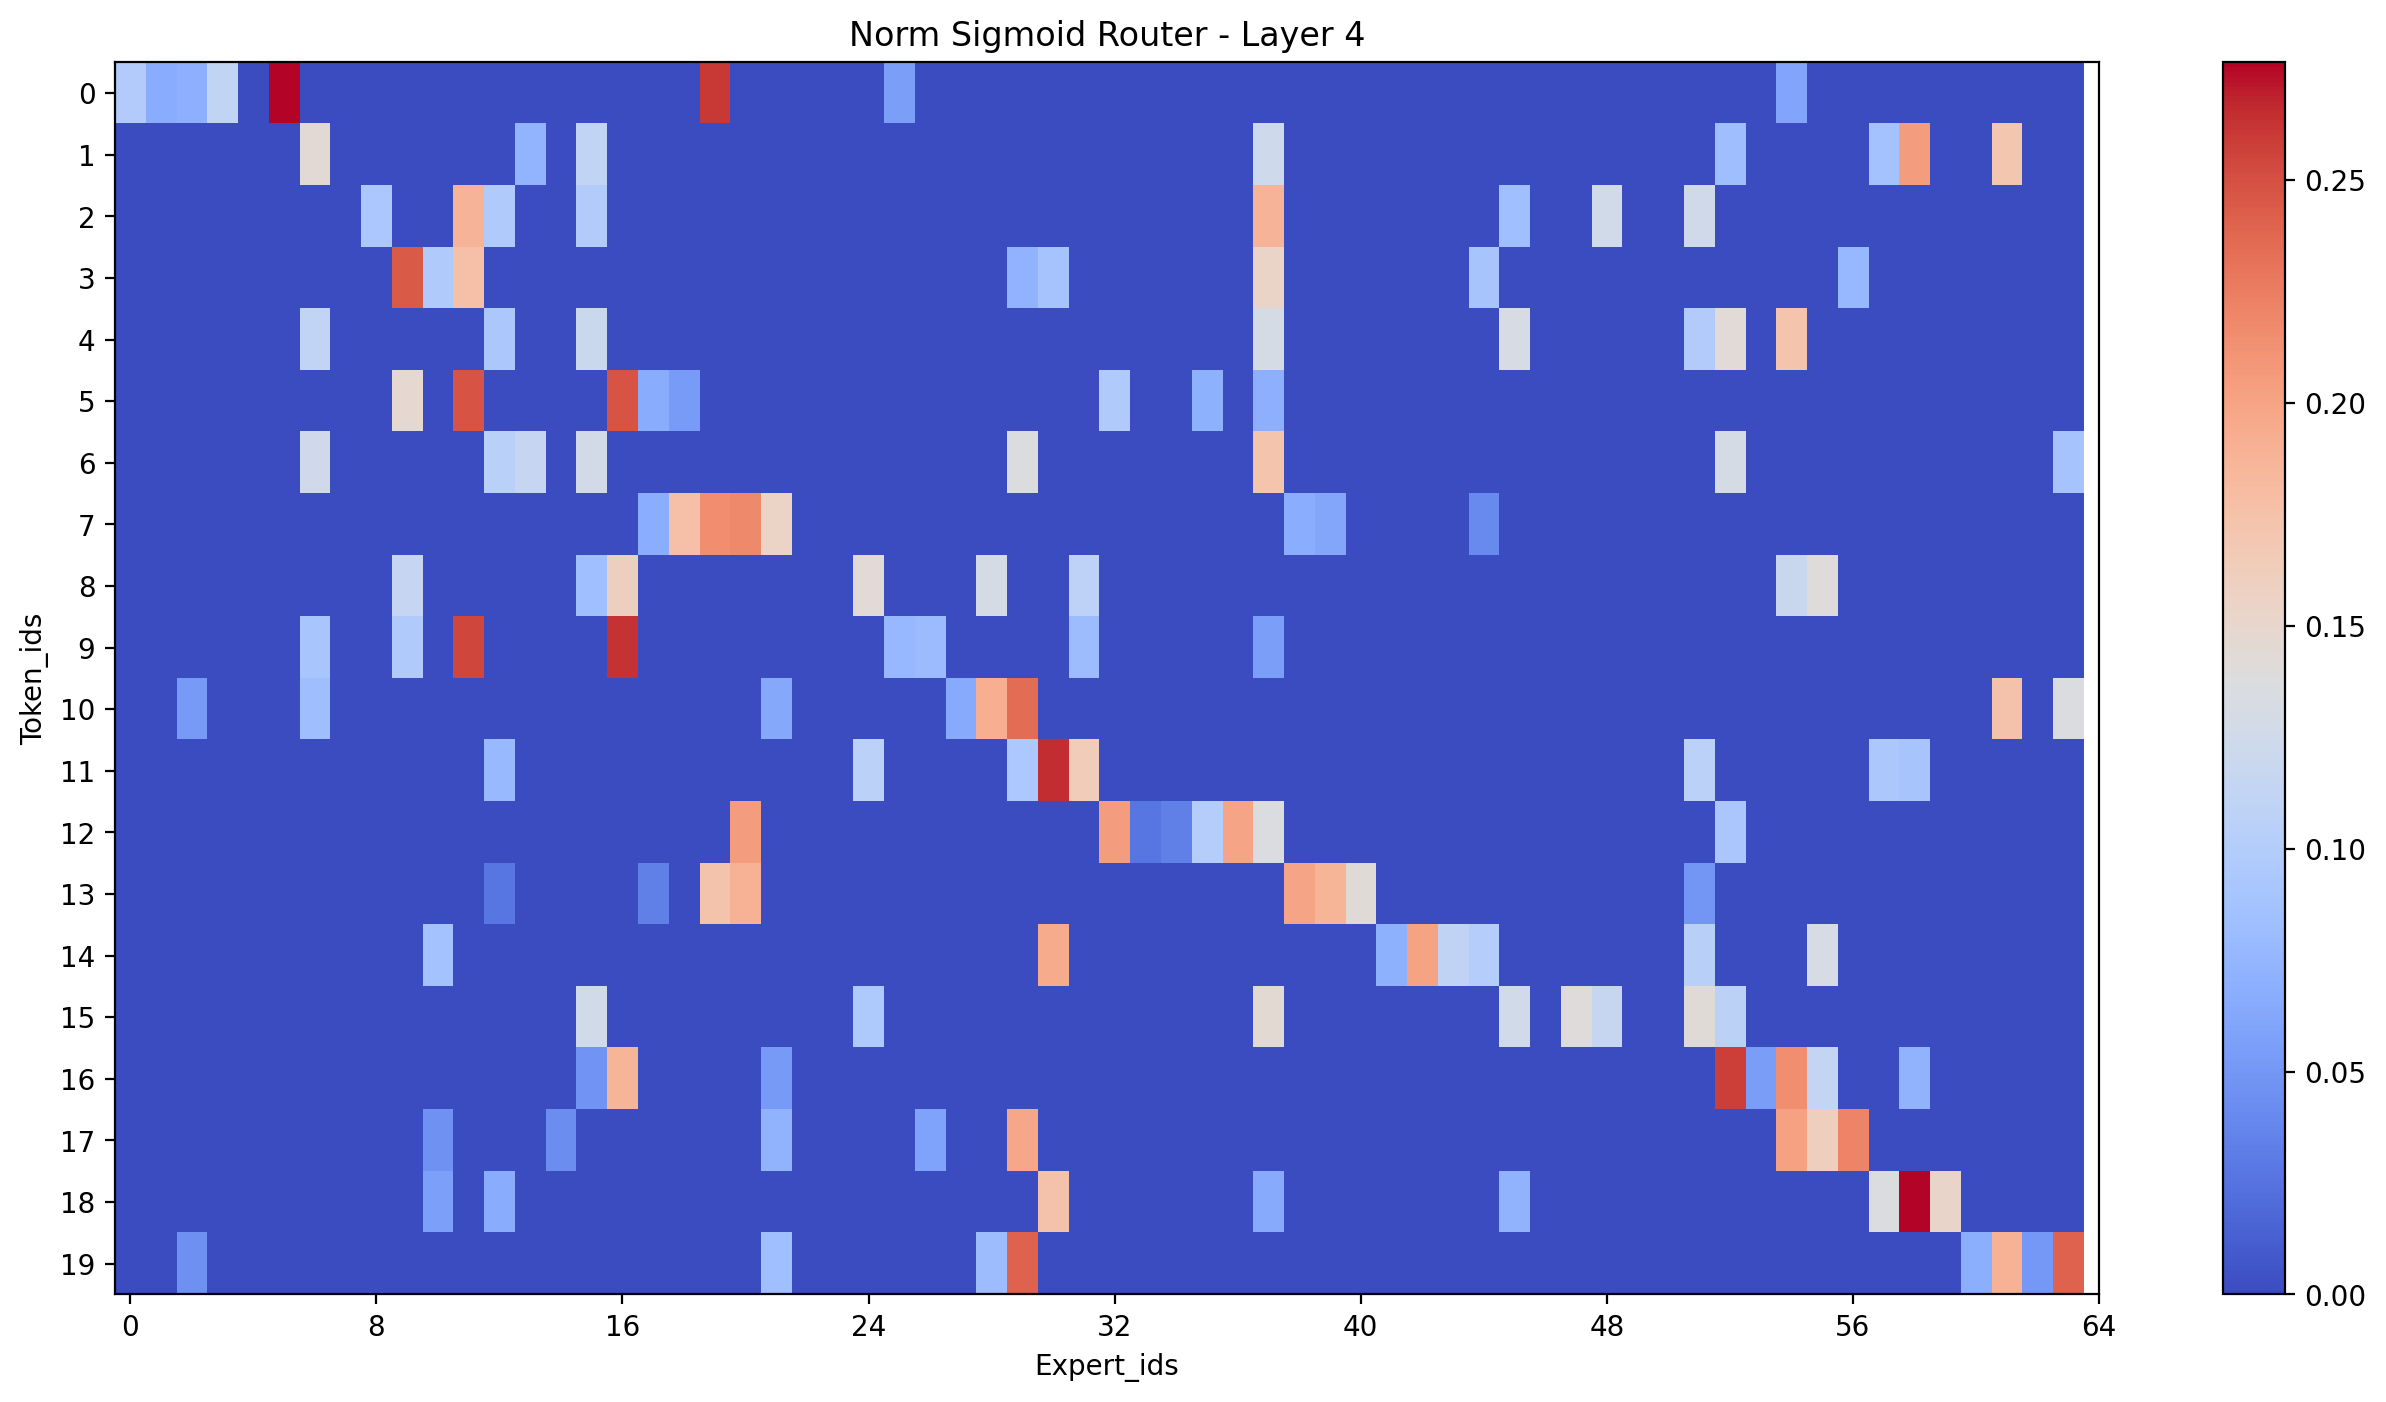

0.2903447


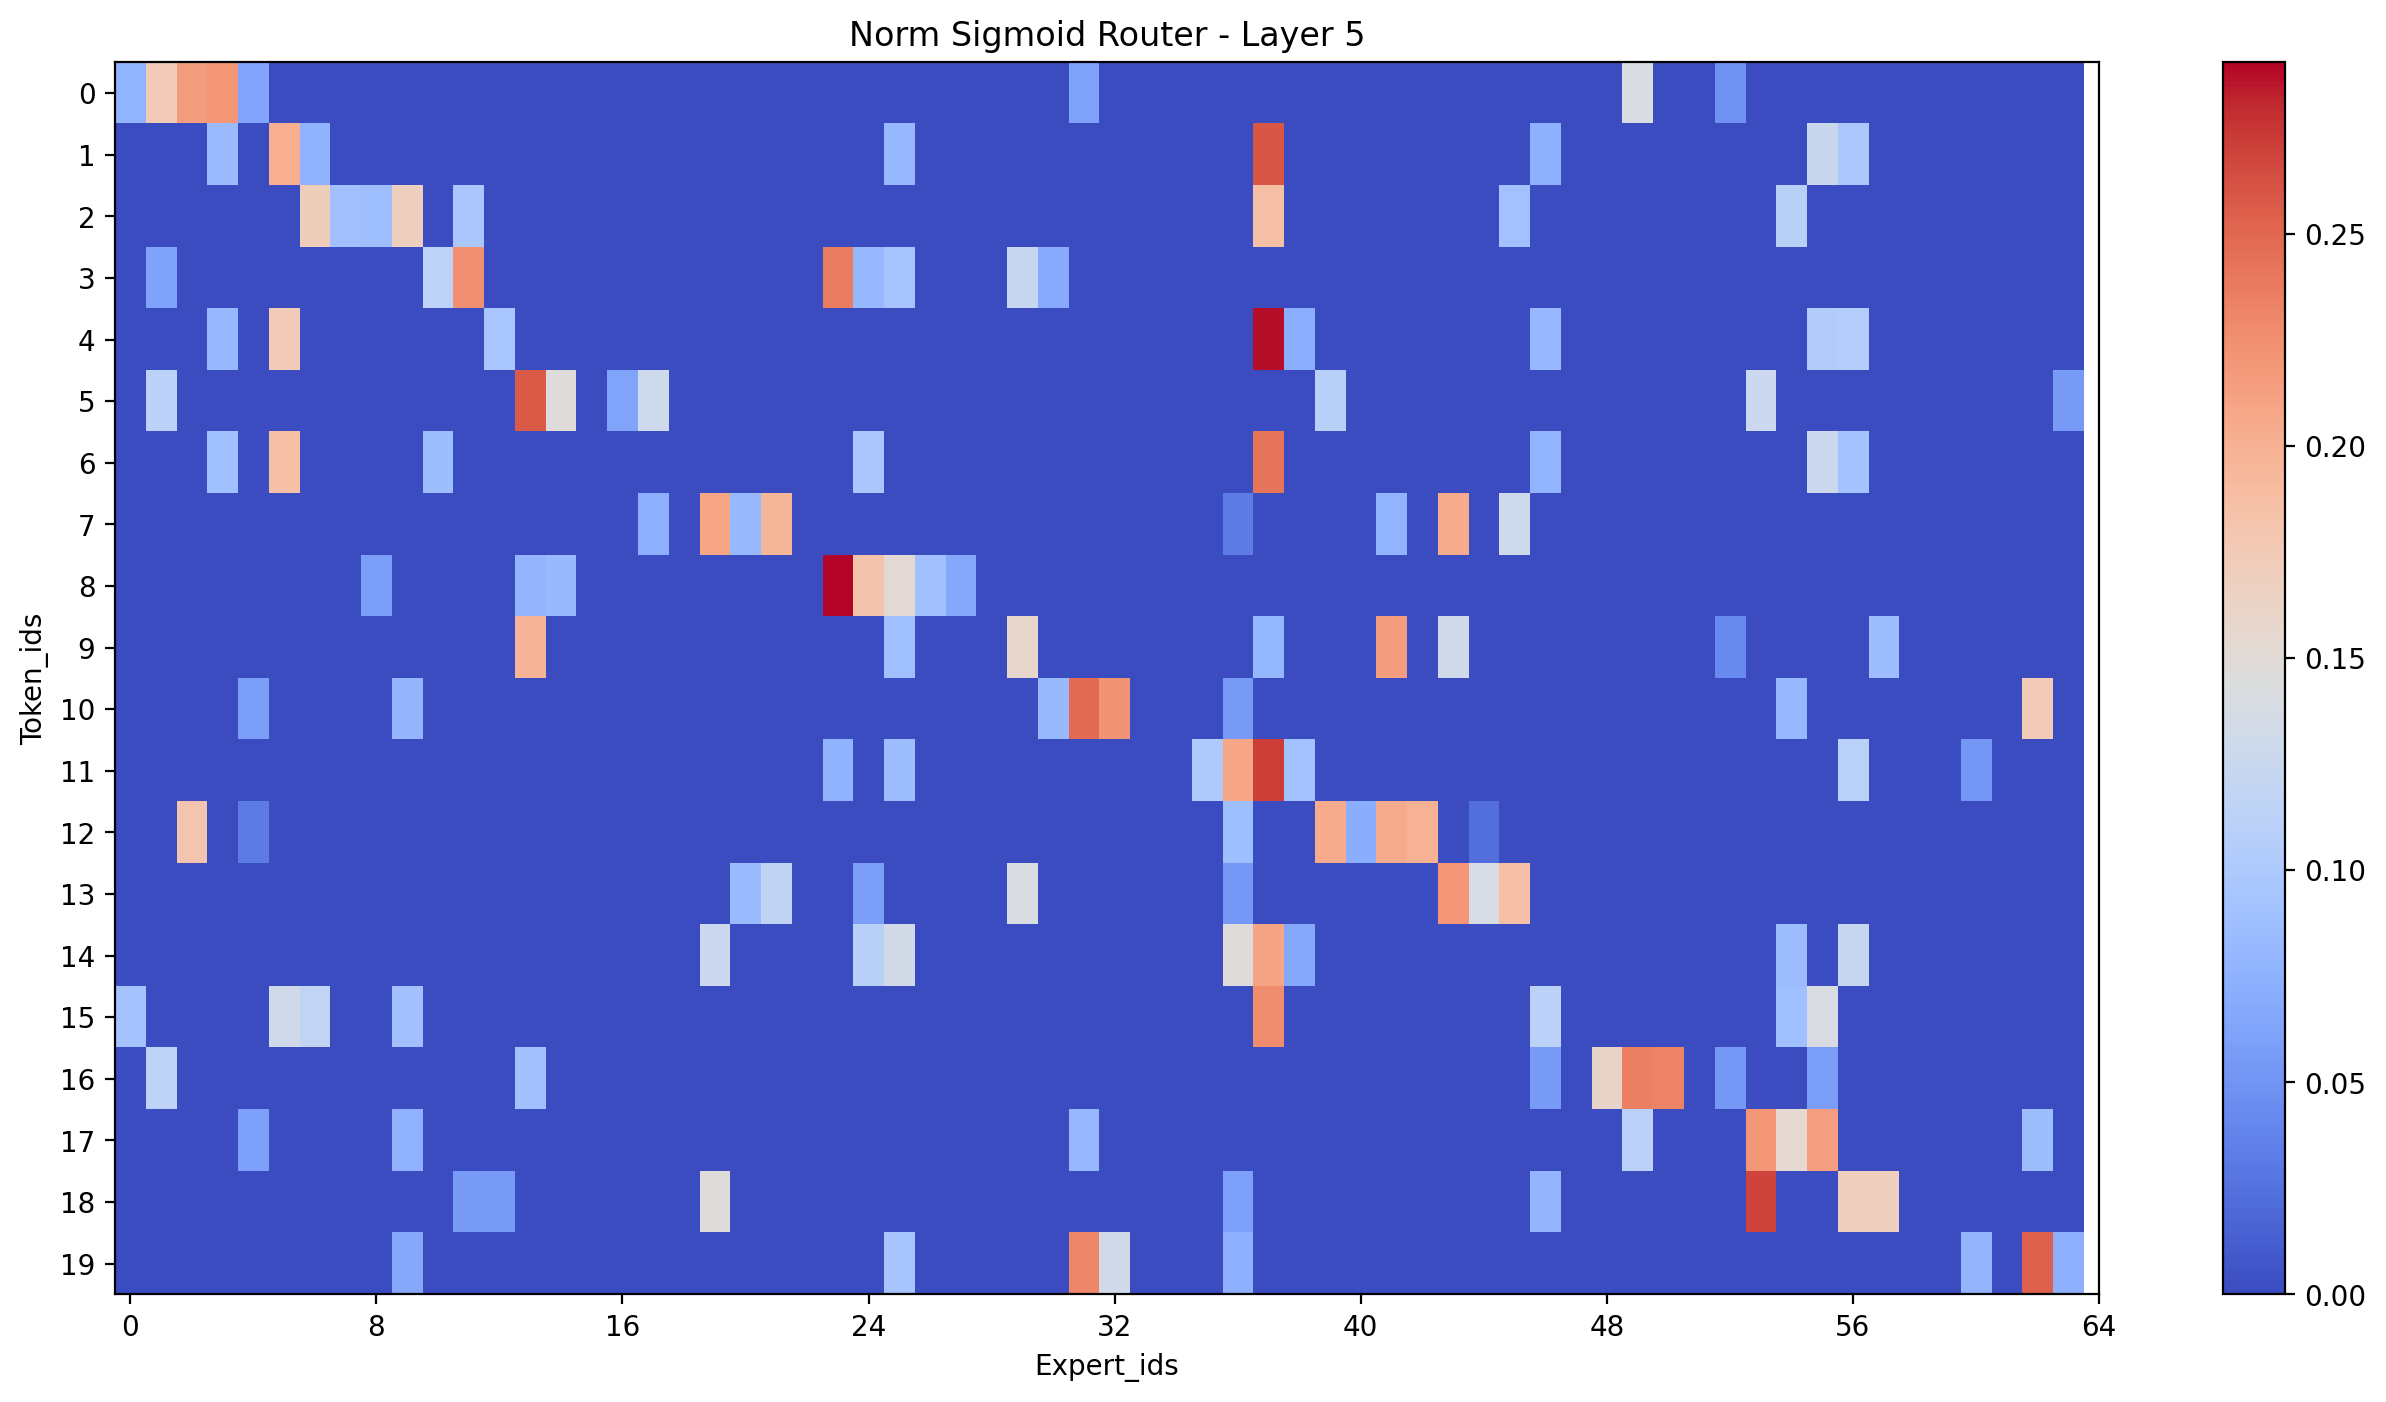

0.29663733


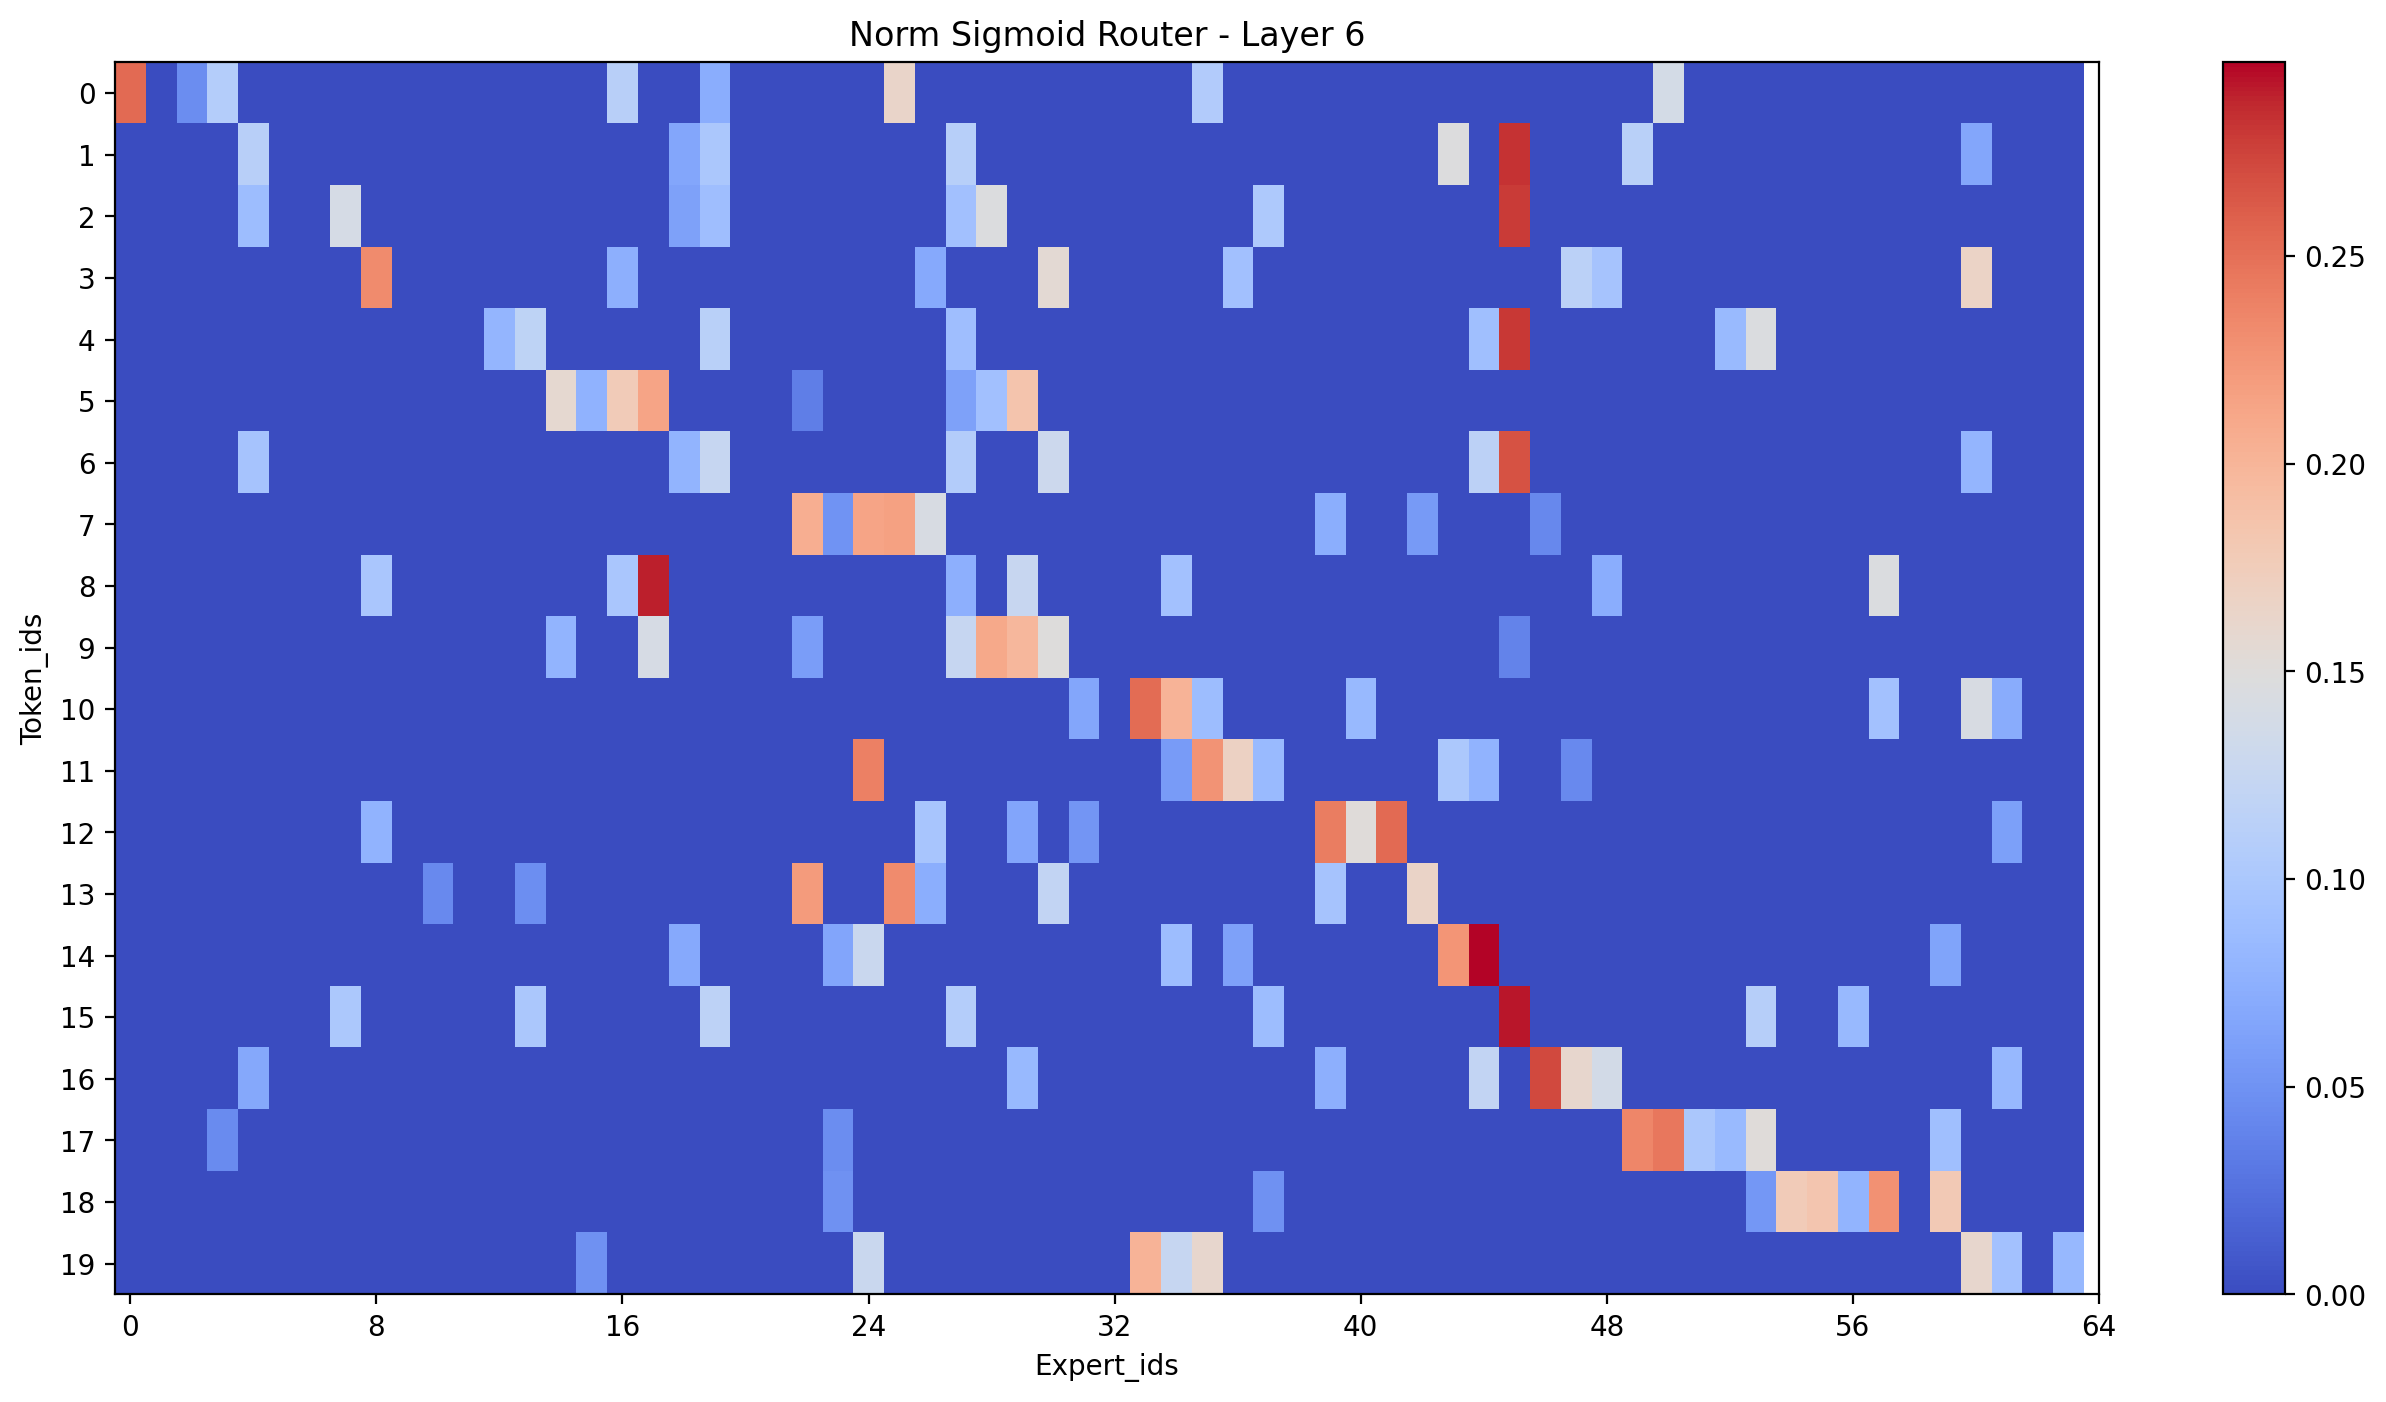

0.24902122


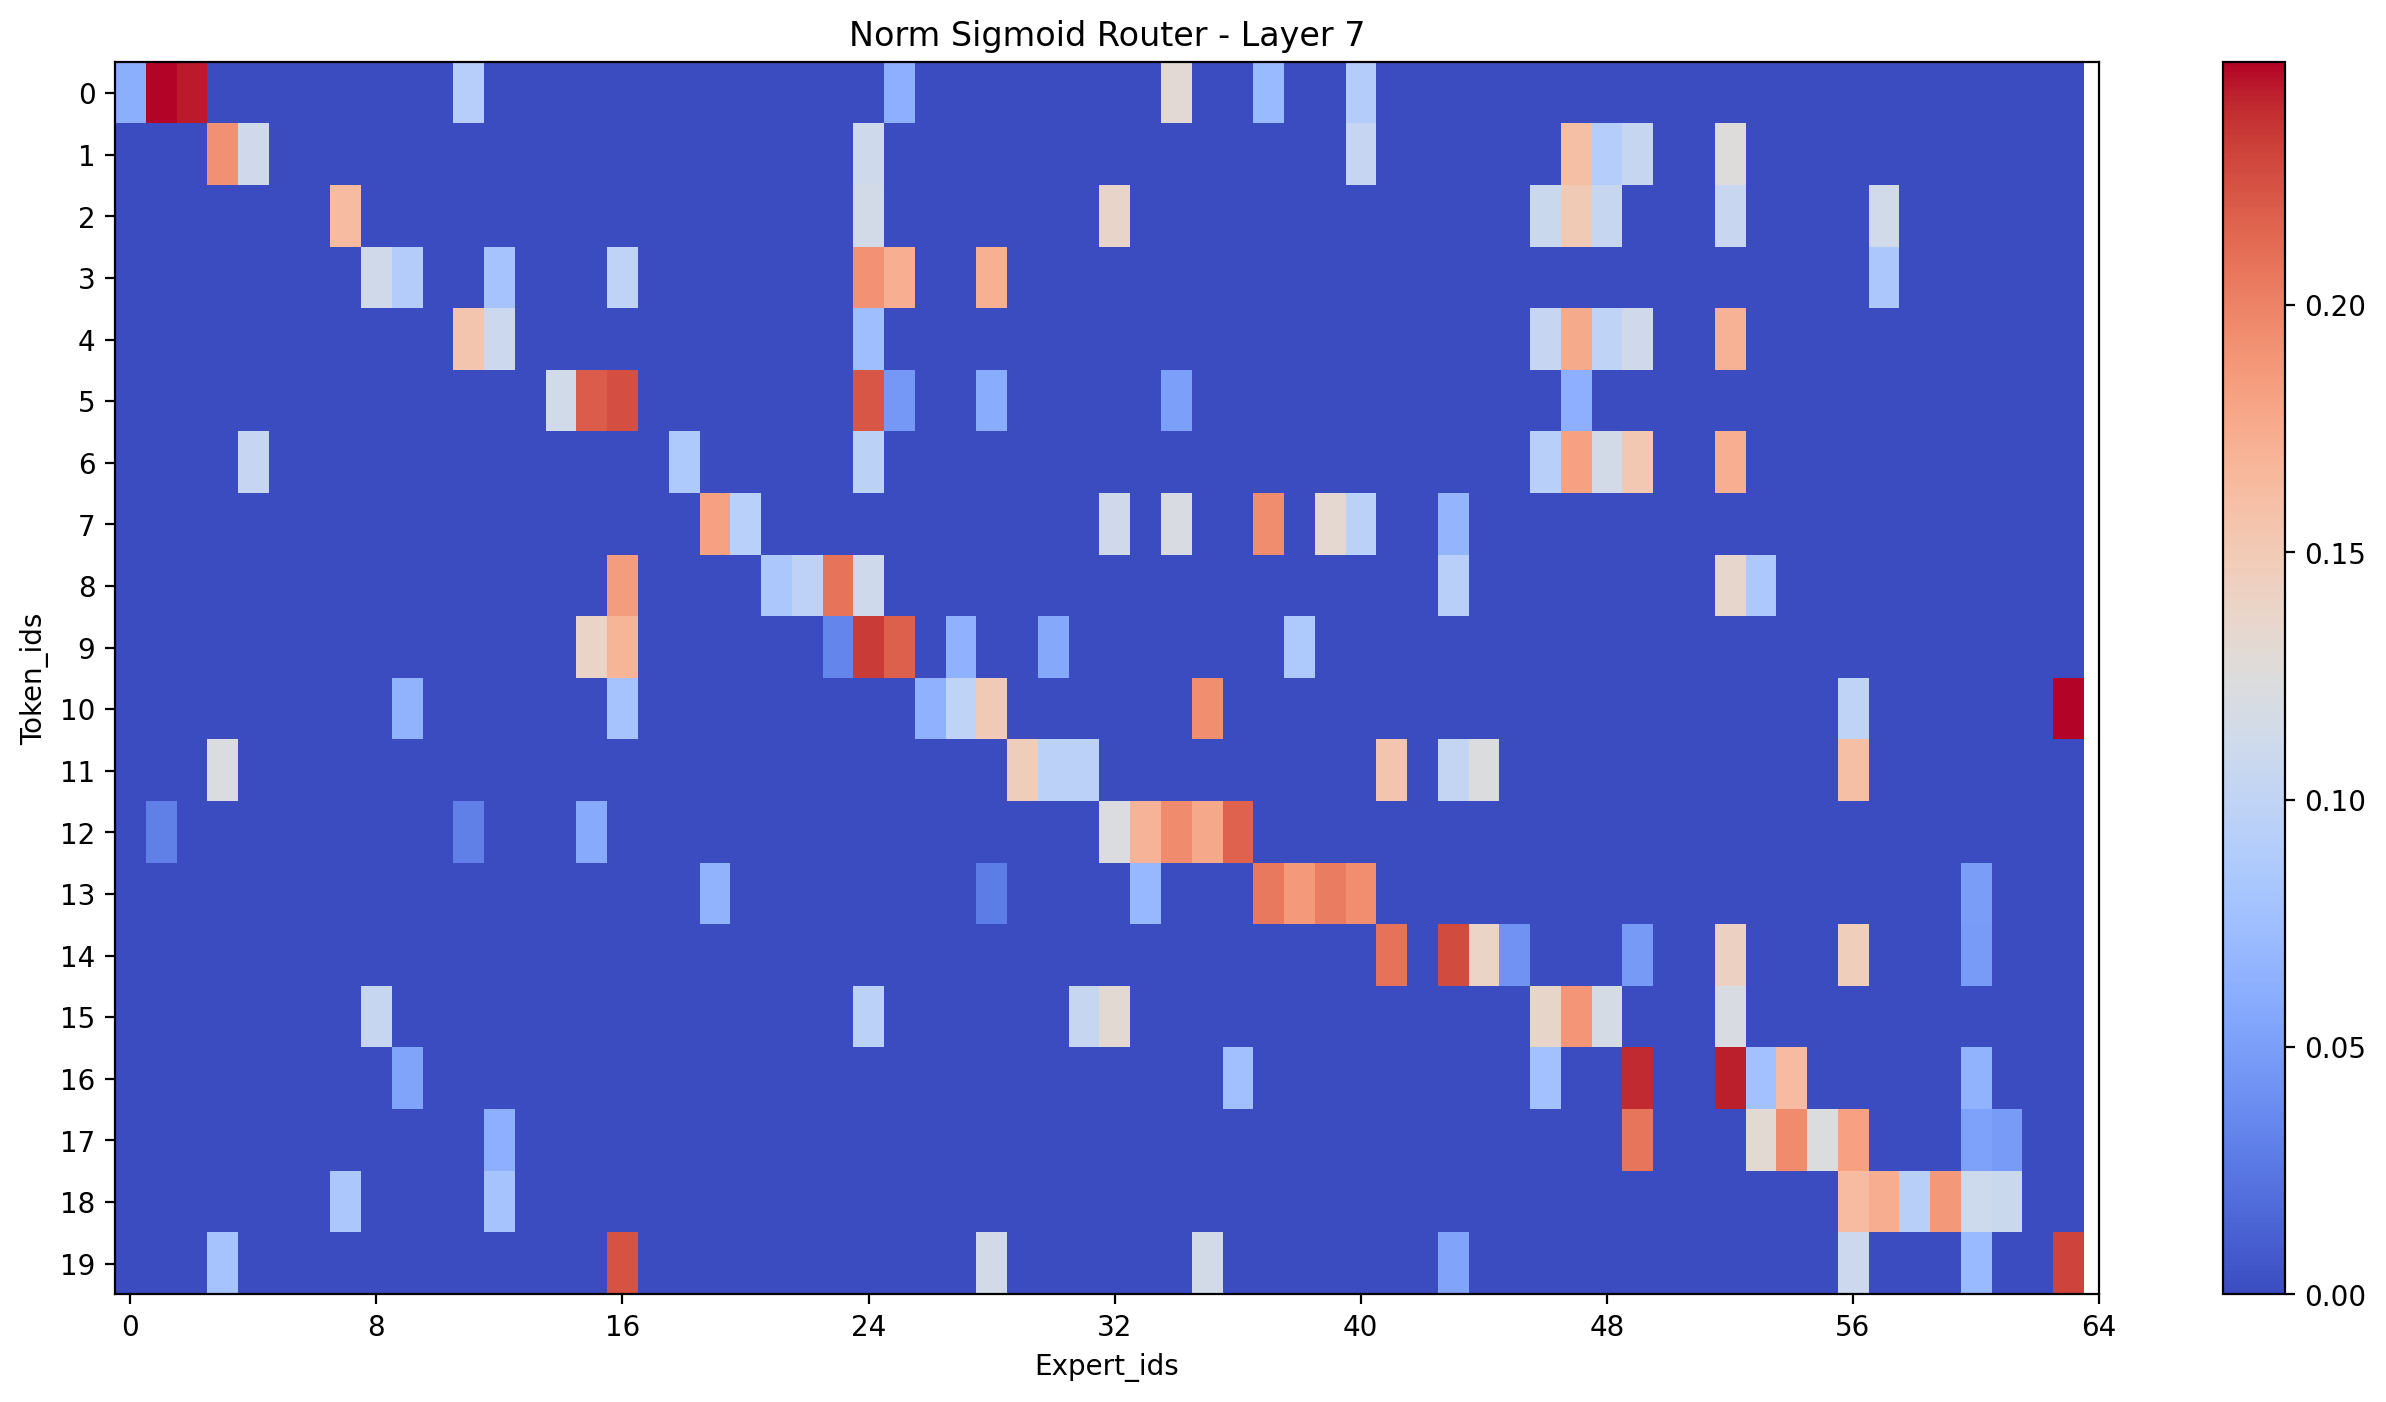

0.2705712


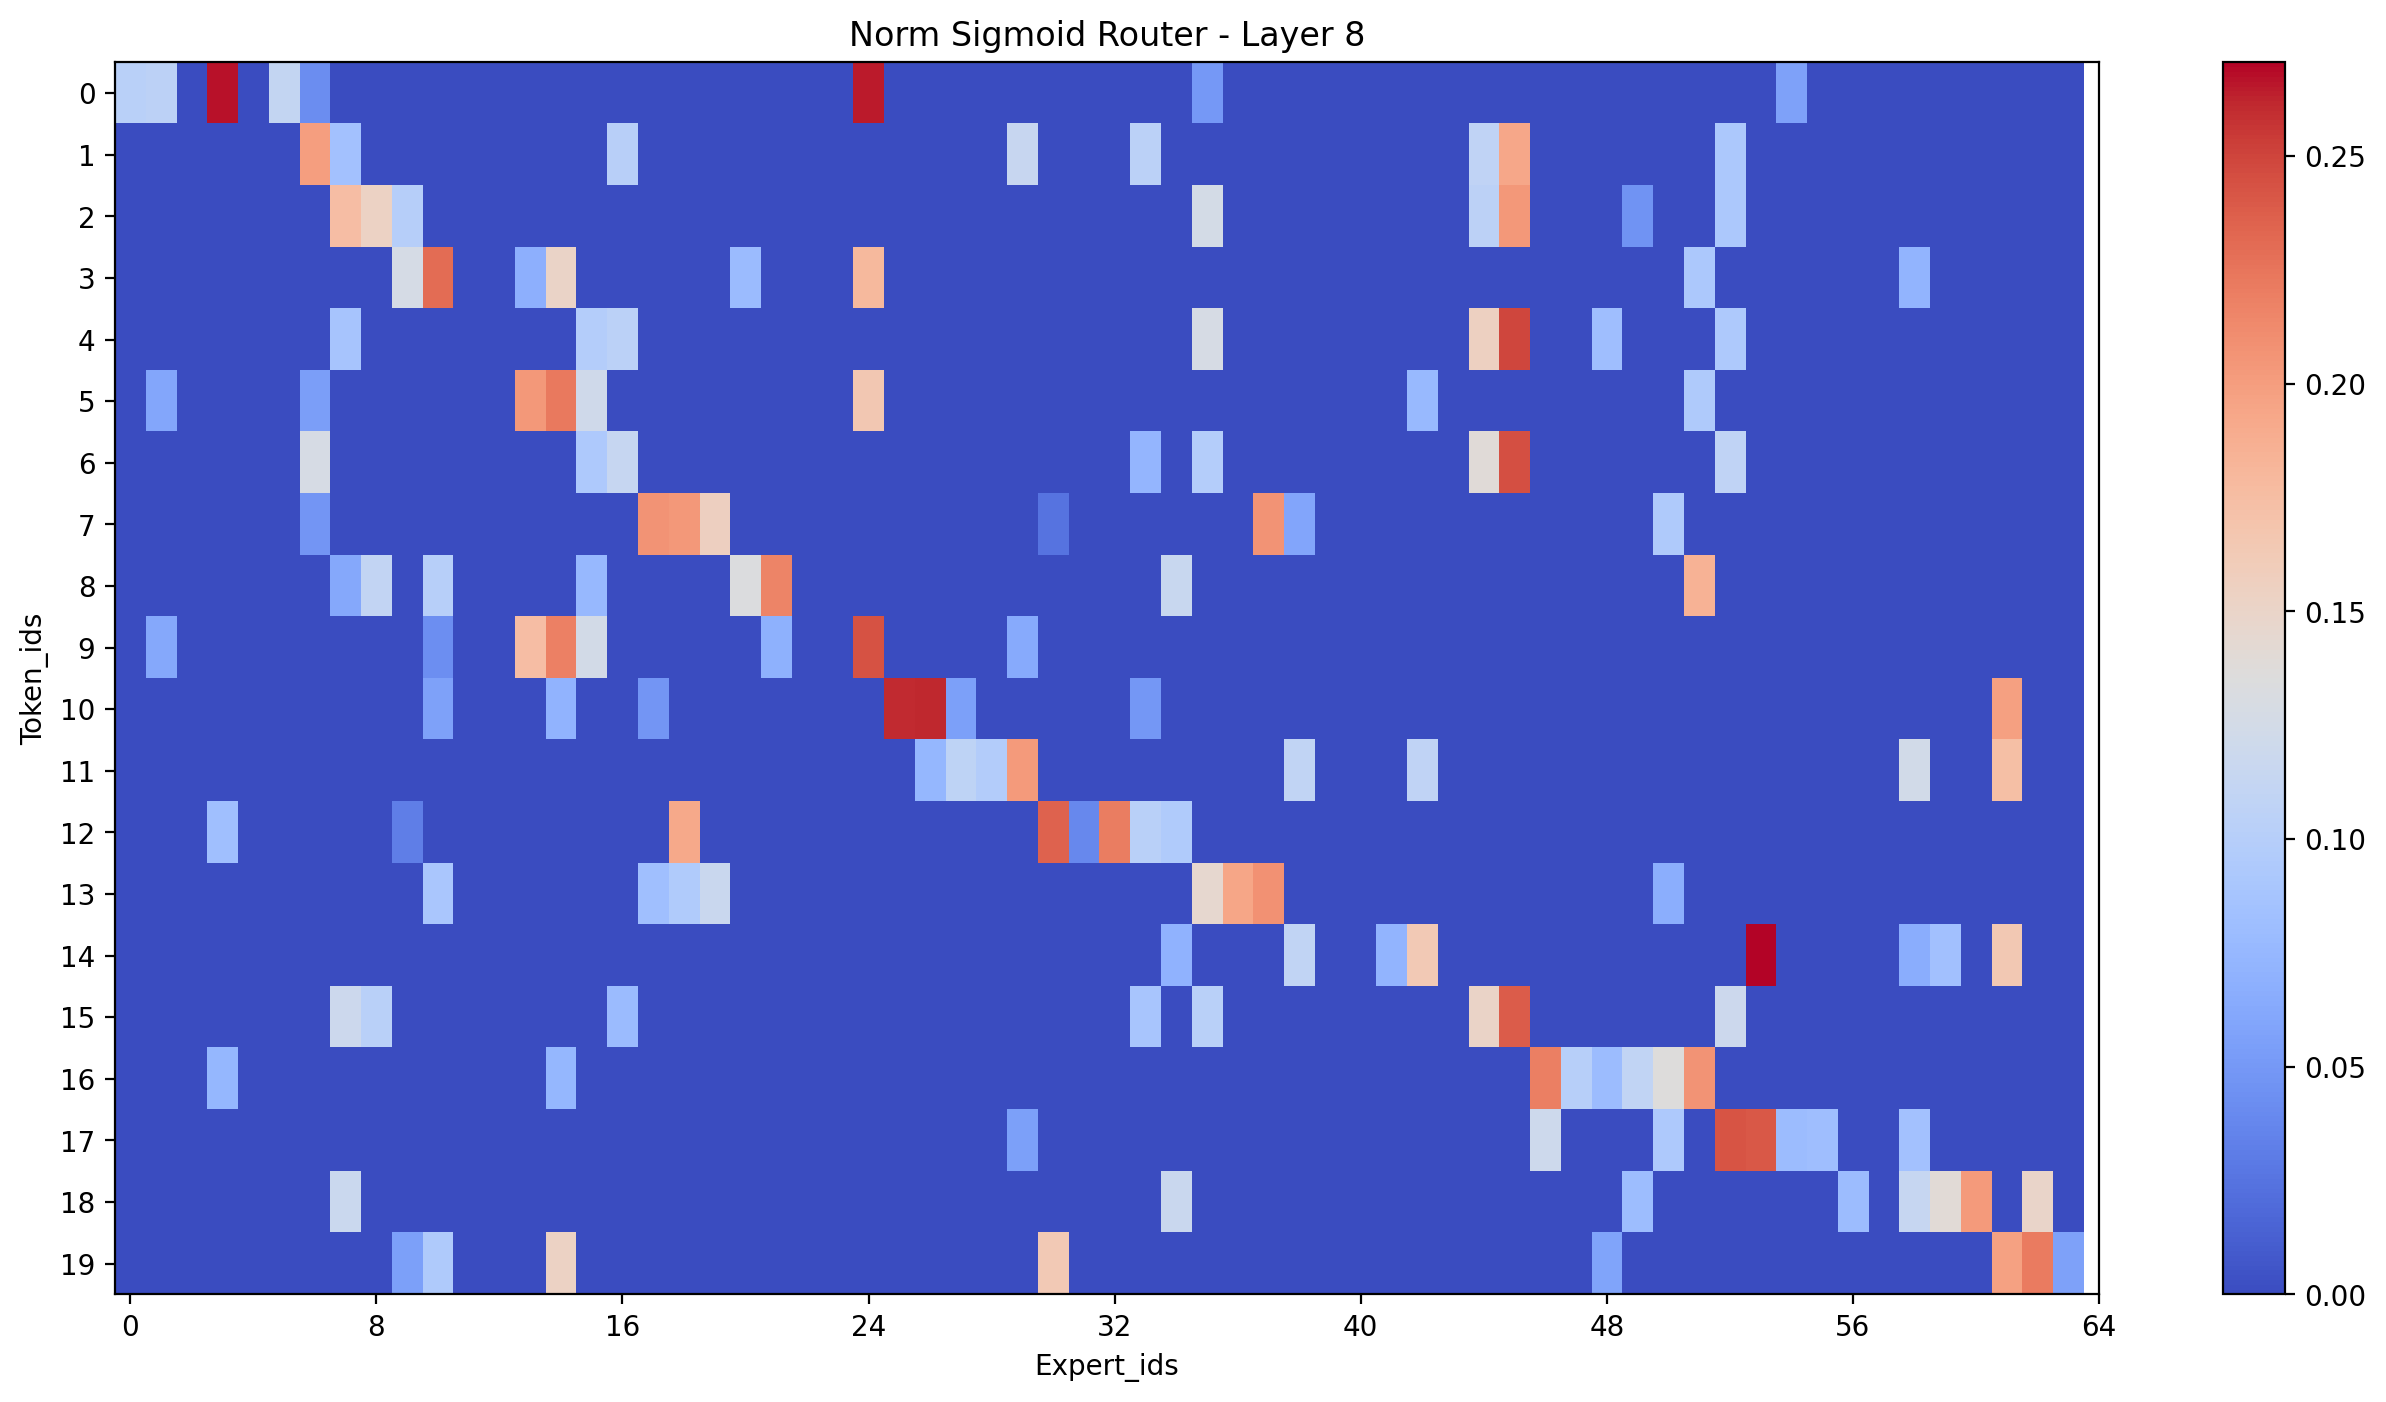

0.27308238


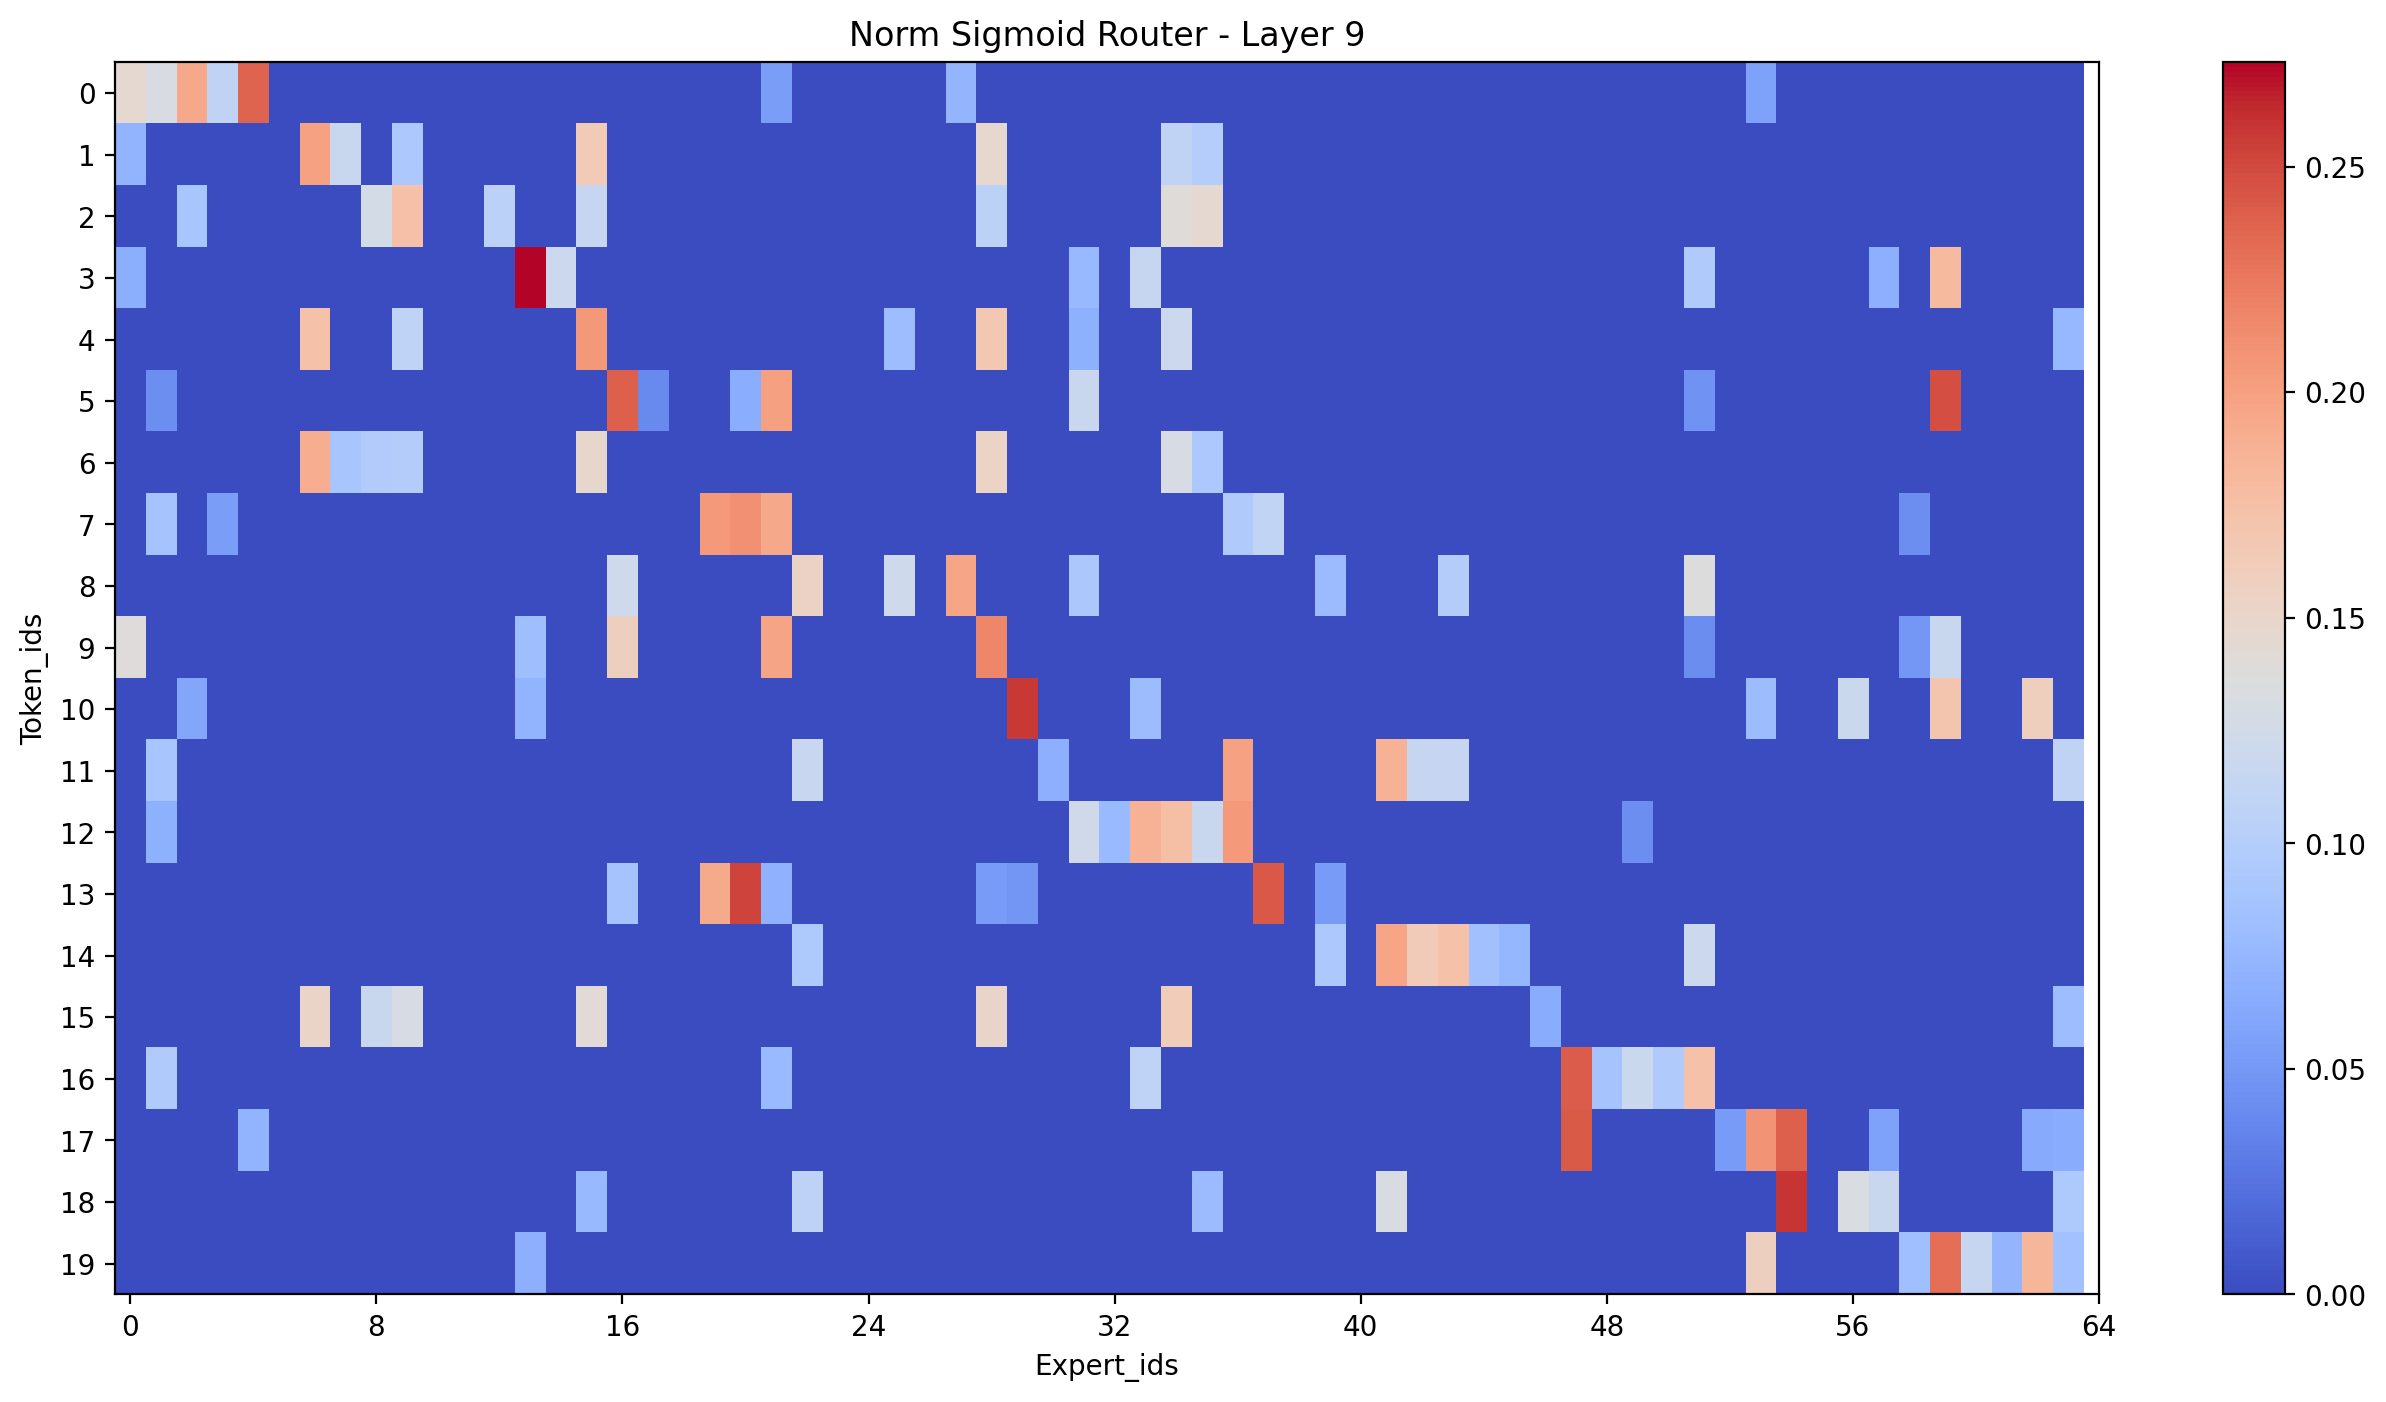

0.28150767


KeyboardInterrupt: 

In [35]:
ostart = 30
count = 20
# gid = 15
layer = 0

max_range = []

for gid in range(16):
    labels = task.train_set.vocabulary(order[ostart:ostart+count].tolist())

    fig, ax=plt.subplots(figsize=(16, 8))
    if layer is None:
        plot_slice = counts_o[gid, :, :, ostart:ostart+count]
        plot_slice = plot_slice.sum(0)
    else:
        plot_slice = counts_o[gid, layer, :, ostart:ostart+count]

    plot_slice = plot_slice / plot_slice.sum(0, keepdim=True)

    plot_slice = plot_slice.T


    # print("Plot slice shape", plot_slice.shape)

    tresh = torch.quantile(plot_slice, 0.95, dim=0, keepdim=True)
    # tresh = 0
    total_counts = plot_slice * (plot_slice >= tresh)
    total_counts = total_counts / total_counts.sum(0, keepdim=True)
    # plot_slice = total_counts
    total_counts = total_counts * torch.arange(plot_slice.shape[0], dtype=torch.float)[..., None]
    total_counts = total_counts.sum(0)
    order3 = total_counts.argsort(descending=False)

    plot_slice_o = plot_slice[:, order3]

    # modify part
    score, index = plot_slice_o.topk(8, dim=-1, sorted=False)
    score = score / (score.sum(dim=-1, keepdim=True) + 1e-20)
    plot_slice_o_topk = torch.zeros_like(plot_slice_o)
    plot_slice_o_topk = plot_slice_o_topk.scatter(-1, index, score)

    # plt.imshow(plot_slice_o_topk.numpy(), aspect='auto', cmap='viridis', interpolation="none")
    img = plt.imshow(plot_slice_o_topk.numpy(), aspect='auto', cmap='coolwarm', interpolation="none")
    plt.yticks(list(range(20)))
    plt.colorbar()
    print(plot_slice_o_topk.numpy().max())
    max_range.append(plot_slice_o_topk.numpy().max())
    # img.set_clim(0, 0.3)  # Adjust colorbar range
    plt.yticks(list(range(20)))
    plt.xticks(list(range(0, 66, 8)))
    plt.xlabel("Expert_ids")
    plt.ylabel("Token_ids")
    plt.title(f"Norm Sigmoid Router - Layer {gid}")

    plt.savefig(f"/cm/shared/anonymous/moeut_training_code/paper/deepseek/figs/softmax/layer_{gid}.pdf", format='pdf', bbox_inches='tight')
    plt.show()

In [54]:
print(max_range)

[0.14919102, 0.27646714, 0.19630484, 0.22510746, 0.24591096, 0.27004638, 0.23917203, 0.23523785, 0.23775388, 0.23173535, 0.25372675, 0.26025873, 0.24722186, 0.22364126, 0.26406586, 0.23566662]


Plot slice shape torch.Size([20, 66])


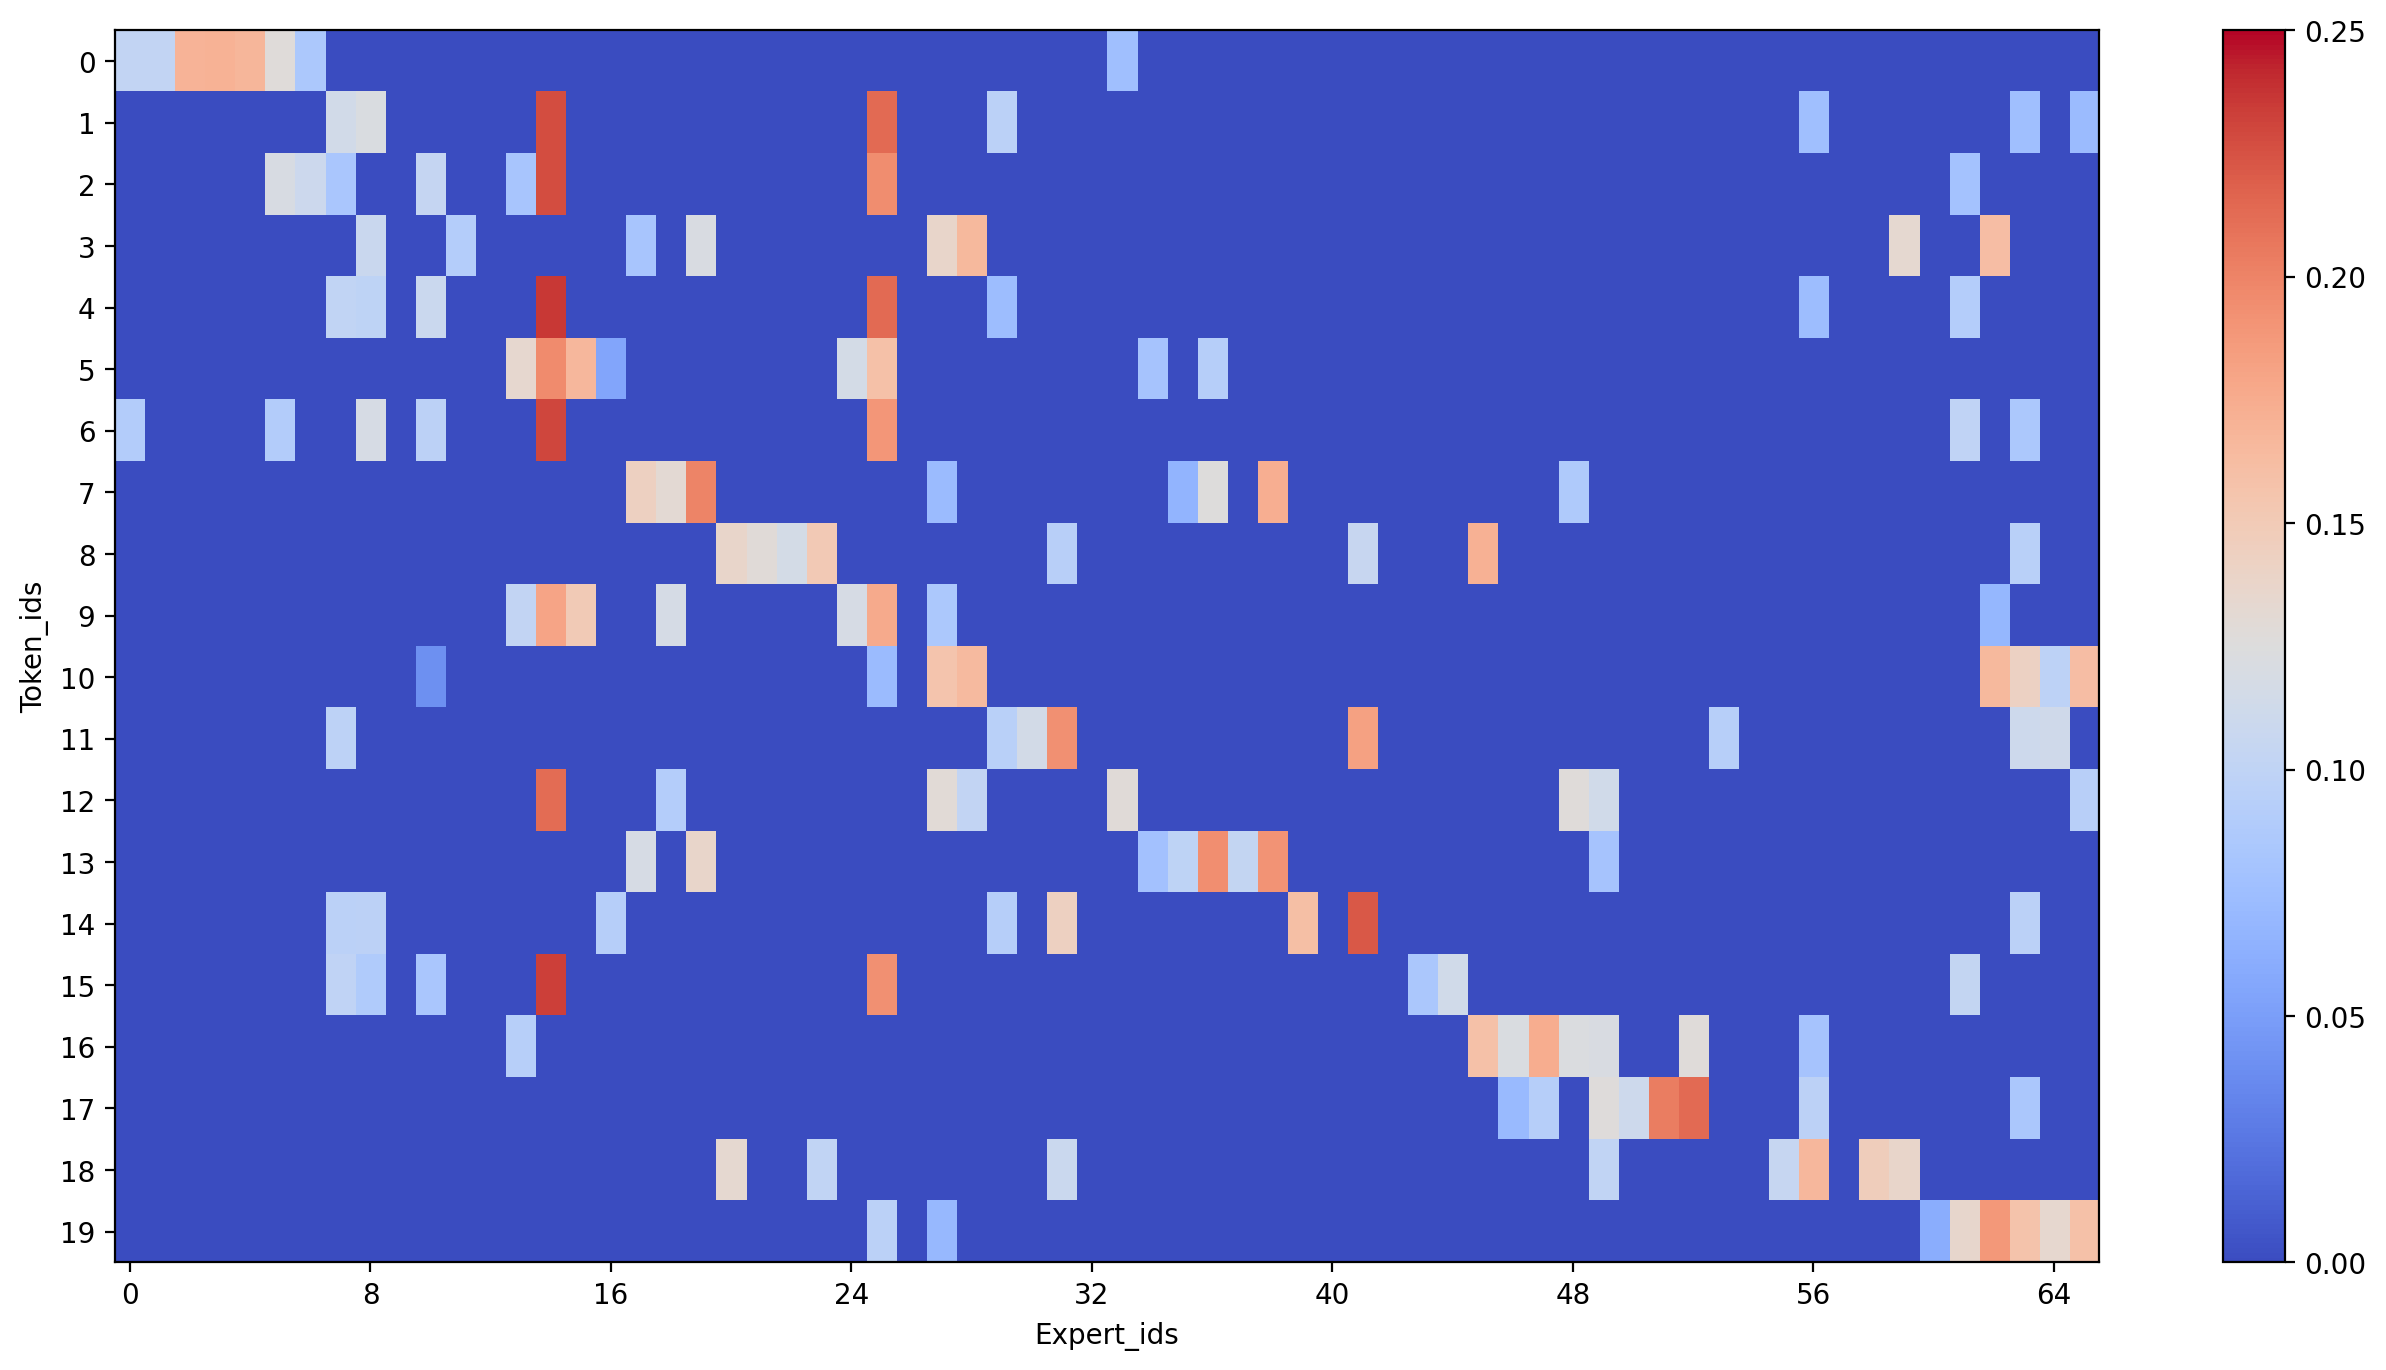

In [28]:
ostart = 30
count = 20
gid = 14
layer = 0


labels = task.train_set.vocabulary(order[ostart:ostart+count].tolist())

fig, ax=plt.subplots(figsize=(16, 8))
if layer is None:
    plot_slice = counts_o[gid, :, :, ostart:ostart+count]
    plot_slice = plot_slice.sum(0)
else:
    plot_slice = counts_o[gid, layer, :, ostart:ostart+count]

plot_slice = plot_slice / plot_slice.sum(0, keepdim=True)

plot_slice = plot_slice.T


print("Plot slice shape", plot_slice.shape)

tresh = torch.quantile(plot_slice, 0.95, dim=0, keepdim=True)
# tresh = 0
total_counts = plot_slice * (plot_slice >= tresh)
total_counts = total_counts / total_counts.sum(0, keepdim=True)
# plot_slice = total_counts
total_counts = total_counts * torch.arange(plot_slice.shape[0], dtype=torch.float)[..., None]
total_counts = total_counts.sum(0)
order3 = total_counts.argsort(descending=False)

plot_slice_o = plot_slice[:, order3]

# modify part
score, index = plot_slice_o.topk(8, dim=-1, sorted=False)
score = score / (score.sum(dim=-1, keepdim=True) + 1e-20)
plot_slice_o_topk = torch.zeros_like(plot_slice_o)
plot_slice_o_topk = plot_slice_o_topk.scatter(-1, index, score)

# plt.imshow(plot_slice_o_topk.numpy(), aspect='auto', cmap='viridis', interpolation="none")
img = plt.imshow(plot_slice_o_topk.numpy(), aspect='auto', cmap='coolwarm', interpolation="none")
plt.yticks(list(range(20)))
plt.colorbar()
img.set_clim(0, 0.25)  # Adjust colorbar range
plt.yticks(list(range(20)))
plt.xticks(list(range(0, 66, 8)))
plt.xlabel("Expert_ids")
plt.ylabel("Token_ids")
plt.show()